<a href="https://colab.research.google.com/github/GabriellJacinto/Electrical-Behaviour-Prediction/blob/main/CMOS/NAND2/Models/simu_1/NAND2_Advanced_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recap

Anteriormente treinamos quatro algoritmos para três variáveis alvo diferentes. Tivemos bons resultados para alguns, piores para outros, mas no geral conseguimos averiguar que Machine Learning pode servir para prever resultados de simulações elétricas. Dessa vez queremos treinar algoritmos mais avançados que nos retornem multi outputs, com uma variação maior de valores nas variáveis explicativas. Os valores a serem permutados nos dados da simulação Monte Carlo (spectre) de um circuito NAND 2 serão:
* NFET Phig*
* PFET Phig*
* Temperature (-25, 25, 0, 50, 75, 100°C)
* Voltage (0.6, 0.7, 0.8, 0.9V)
* Capacitance (1f, 4f, 8f, 16f)
* Fins (1, 2, 3, 4, 5)
* Hfin (3.2e-8)
* Length (2.1e-8)

Os nossos algoritmos precisam prever em um output (preferencialmente) as variáveis de energia, atraso de subida e atraso de descida (```iint```, ```tplh``` e ```tphl```respectivamente). **Não irei trabalhar com regressores lineares dessa vez**. Alguns algoritmos que tenho em mente:
   

- [ ] Uma ou duas arquiteturas de Rede Neural
- [ ] SVR com um kernel polinomial ou similar
- [ ] RandomForest
- [ ] MultiOutputEstimator para os últimos dois



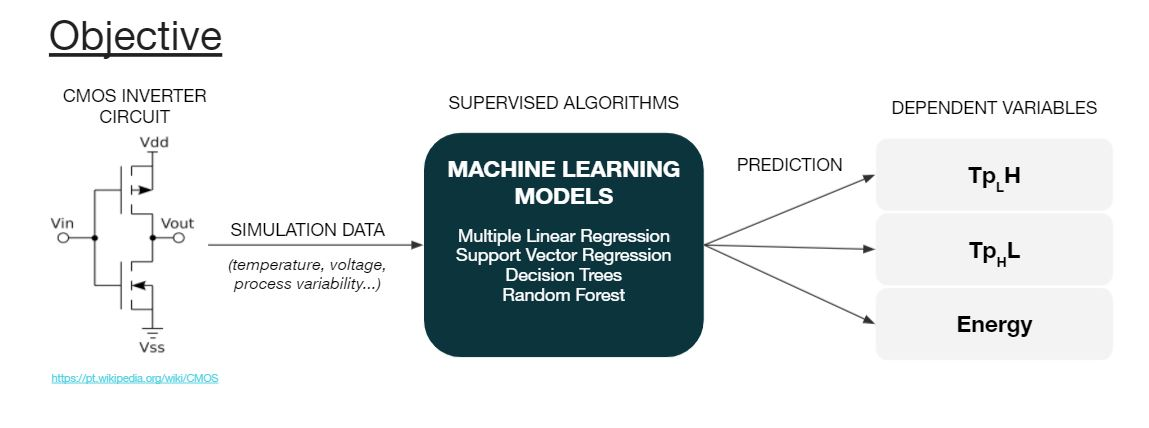

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import logging

In [2]:
!pwd

/Users/gabriellimajacinto/Documents/Electrical-Behaviour-Prediction/FINFET/5nm/NOT/Model


In [3]:
results_dir = "../../../Model/results/"

logger = logging.getLogger()
fhandler = logging.FileHandler(filename='results_log.txt', mode='a')
logger.setLevel(logging.INFO)#send two messages to the logger
logger.addHandler(fhandler)

In [4]:
path = "../Data/sim1"
os.chdir(path)
print("Current path:", os.getcwd())
print("Files:")
for file in os.listdir():
  print(" ", file)

Current path: /Users/gabriellimajacinto/Documents/Electrical-Behaviour-Prediction/FINFET/5nm/NOT/Data/sim1
Files:
  results_log.txt
  treated_data_inverter.csv
  simResults_NOT5fet
  params.json
  inverter.sp
  var.sp
  all_results.csv


# Ajustando o .csv

In [5]:
data = pd.read_csv('all_results.csv', index_col=0)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8400 entries, 0 to 8399
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   nmos_rvt:@:nfet_phig:@:IGNC  8400 non-null   float64
 1   pmos_rvt:@:pfet_phig:@:IGNC  8400 non-null   float64
 2   LoadCap                      8400 non-null   object 
 3   vdd                          8400 non-null   float64
 4   number_fin                   8400 non-null   int64  
 5   t_fall_delay                 8400 non-null   float64
 6   t_rise_delay                 8400 non-null   float64
 7   iint                         8400 non-null   float64
 8   temper                       8400 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 656.2+ KB


In [7]:
#data = data.apply(pd.to_numeric, errors='coerce')
data.isna().sum()

nmos_rvt:@:nfet_phig:@:IGNC    0
pmos_rvt:@:pfet_phig:@:IGNC    0
LoadCap                        0
vdd                            0
number_fin                     0
t_fall_delay                   0
t_rise_delay                   0
iint                           0
temper                         0
dtype: int64

In [8]:
data = data.dropna()
data.isna().sum()

nmos_rvt:@:nfet_phig:@:IGNC    0
pmos_rvt:@:pfet_phig:@:IGNC    0
LoadCap                        0
vdd                            0
number_fin                     0
t_fall_delay                   0
t_rise_delay                   0
iint                           0
temper                         0
dtype: int64

In [9]:
data = data.rename(columns={'nmos_rvt:@:nfet_phig:@:IGNC': 'nfetPhig', 
                            'pmos_rvt:@:pfet_phig:@:IGNC': 'pfetPhig',
                            'vdd': 'voltage', 
                            'temper': 'temperature',
                            'LoadCap': 'capacitance',
                            'temp': 'temperature',
                            'number_fin': 'finsNumber',
                            'montecarlo_iteration': 'monteCarloIteration',
                            'total_power': 'totalPower',
                            'iint': 'energy',
                            't_fall_delay': 'tphL',
                            't_rise_delay': 'tplH'
                            })

# data = data.drop("temper", axis=1)
# data = data.drop("alter", axis=1)
# data = data.drop("index", axis=1)

data["finLength"] = 2.1e-8
data["finHeight"] = 3.2e-8

In [10]:
data["capacitance"] = data["capacitance"].map(lambda x: (float(x[:-1]))*10**(-15))

In [11]:
data.capacitance.unique()

array([1.e-15, 2.e-15, 3.e-15, 4.e-15])

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8400 entries, 0 to 8399
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   nfetPhig     8400 non-null   float64
 1   pfetPhig     8400 non-null   float64
 2   capacitance  8400 non-null   float64
 3   voltage      8400 non-null   float64
 4   finsNumber   8400 non-null   int64  
 5   tphL         8400 non-null   float64
 6   tplH         8400 non-null   float64
 7   energy       8400 non-null   float64
 8   temperature  8400 non-null   float64
 9   finLength    8400 non-null   float64
 10  finHeight    8400 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 787.5 KB


In [13]:
data.to_csv('treated_data_inverter.csv') 

# Limpando e Explorando os Dados

In [14]:
data = pd.read_csv("treated_data_inverter.csv", index_col=0)
data.head()

nfetPhig  pfetPhig   capacitance  voltage  finsNumber          tphL  \
0    0.0000    0.0000  1.000000e-15      0.6           1  3.122601e-11   
1   -0.8014   -0.8294  1.000000e-15      0.6           1  3.645914e-11   
2   -0.2677    0.2150  1.000000e-15      0.6           1  3.012202e-11   
3    1.6757    0.8946  1.000000e-15      0.6           1  2.623752e-11   
4    0.2014    1.0447  1.000000e-15      0.6           1  2.599074e-11   

           tplH        energy  temperature     finLength     finHeight  
0  1.384210e-11 -5.634690e-15         50.0  2.100000e-08  3.200000e-08  
1  1.213240e-11 -5.658039e-15         50.0  2.100000e-08  3.200000e-08  
2  1.322730e-11 -5.656815e-15         50.0  2.100000e-08  3.200000e-08  
3  1.826387e-11 -5.504315e-15         50.0  2.100000e-08  3.200000e-08  
4  1.431080e-11 -5.521897e-15         50.0  2.100000e-08  3.200000e-08

In [15]:
data.describe()

nfetPhig     pfetPhig   capacitance      voltage   finsNumber  \
count  8400.000000  8400.000000  8.400000e+03  8400.000000  8400.000000   
mean     -0.221955     0.229750  2.500000e-15     0.700000     3.000000   
std       1.048387     0.989976  1.118101e-15     0.081655     1.414298   
min      -2.450200    -1.289700  1.000000e-15     0.600000     1.000000   
25%      -0.912000    -0.469650  1.750000e-15     0.600000     2.000000   
50%       0.100700     0.293300  2.500000e-15     0.700000     3.000000   
75%       0.567125     0.850800  3.250000e-15     0.800000     4.000000   
max       1.675700     2.774200  4.000000e-15     0.800000     5.000000   

               tphL          tplH        energy  temperature     finLength  \
count  8.400000e+03  8.400000e+03  8.400000e+03  8400.000000  8.400000e+03   
mean   2.619488e-11  2.154814e-11 -1.641259e-14    50.000000  2.100000e-08   
std    2.267567e-11  1.763893e-11  7.599625e-15    50.002976  6.617839e-24   
min    3.292204e-12  3.150259e-12 -3.242415e-14   -25.000000  2.100000e-08   
25%    1.148423e-11  1.009328e-11 -2.247915e-14     0.000000  2.100000e-08   
50%    1.895135e-11  1.587894e-11 -1.645100e-14    50.000000  2.100000e-08   
75%    3.153938e-11  2.559569e-11 -1.080579e-14   100.000000  2.100000e-08   
max    1.713674e-10  1.391462e-10 -5.440730e-15   125.000000  2.100000e-08   

          finHeight  
count  8.400000e+03  
mean   3.200000e-08  
std    6.617839e-24  
min    3.200000e-08  
25%    3.200000e-08  
50%    3.200000e-08  
75%    3.200000e-08  
max    3.200000e-08

In [16]:
inp_var = ["capacitance", "voltage", "finHeight", "finLength", "temperature", "finsNumber"]
unique = {}
for col in inp_var:
  unique[col] = list(np.sort(data[col].unique()))
tmp = data[inp_var]
# Verifica quantas vezes o mesmo caso é repetido
n_repetitions = tmp.shape[0]
for i in range(1, tmp.shape[0]):
  if (not tmp.iloc[0].equals(tmp.iloc[i])):
    n_repetitions = i
    break

n_cases = tmp.shape[0]//n_repetitions
idx = []
idx.append(np.vstack([np.arange(n_cases)]*n_repetitions).T.reshape(-1))
idx.append(np.concatenate([np.arange(n_repetitions)]*n_cases))
data.index = pd.MultiIndex.from_tuples(list(zip(*idx)), names=["case", "idx"])
data

nfetPhig  pfetPhig   capacitance  voltage  finsNumber          tphL  \
case idx                                                                        
0    0      0.0000    0.0000  1.000000e-15      0.6           1  3.122601e-11   
     1     -0.8014   -0.8294  1.000000e-15      0.6           1  3.645914e-11   
     2     -0.2677    0.2150  1.000000e-15      0.6           1  3.012202e-11   
     3      1.6757    0.8946  1.000000e-15      0.6           1  2.623752e-11   
     4      0.2014    1.0447  1.000000e-15      0.6           1  2.599074e-11   
...            ...       ...           ...      ...         ...           ...   
419  15     0.3824    0.9694  4.000000e-15      0.8           5  1.148789e-11   
     16    -1.8849    0.6073  4.000000e-15      0.8           5  1.183639e-11   
     17     0.8013    0.2451  4.000000e-15      0.8           5  1.231166e-11   
     18    -1.3209    0.8362  4.000000e-15      0.8           5  1.169401e-11   
     19    -2.4502   -1.2897  4.000000e-15      0.8           5  1.478603e-11   

                  tplH        energy  temperature     finLength     finHeight  
case idx                                                                       
0    0    1.384210e-11 -5.634690e-15         50.0  2.100000e-08  3.200000e-08  
     1    1.213240e-11 -5.658039e-15         50.0  2.100000e-08  3.200000e-08  
     2    1.322730e-11 -5.656815e-15         50.0  2.100000e-08  3.200000e-08  
     3    1.826387e-11 -5.504315e-15         50.0  2.100000e-08  3.200000e-08  
     4    1.431080e-11 -5.521897e-15         50.0  2.100000e-08  3.200000e-08  
...                ...           ...          ...           ...           ...  
419  15   1.946184e-11 -2.984134e-14        -25.0  2.100000e-08  3.200000e-08  
     16   1.415969e-11 -2.970630e-14        -25.0  2.100000e-08  3.200000e-08  
     17   2.045281e-11 -3.036800e-14        -25.0  2.100000e-08  3.200000e-08  
     18   1.519424e-11 -2.959505e-14        -25.0  2.100000e-08  3.200000e-08  
     19   1.322078e-11 -2.982571e-14        -25.0  2.100000e-08  3.200000e-08  

[8400 rows x 11 columns]

In [17]:
from scipy.stats import zscore
out_var = ["tphL", "tphL", "energy"]
filtered_list = []
for case in data.index.unique(level="case"):
    tmp = data.loc[slice(case, case), :]
    not_outlier = (np.abs(zscore(tmp[out_var])) < 3).all(axis=1)
    filtered_list.append(tmp[not_outlier])
filtered = pd.concat(filtered_list)
filtered

nfetPhig  pfetPhig   capacitance  voltage  finsNumber          tphL  \
case idx                                                                        
0    0      0.0000    0.0000  1.000000e-15      0.6           1  3.122601e-11   
     1     -0.8014   -0.8294  1.000000e-15      0.6           1  3.645914e-11   
     2     -0.2677    0.2150  1.000000e-15      0.6           1  3.012202e-11   
     3      1.6757    0.8946  1.000000e-15      0.6           1  2.623752e-11   
     4      0.2014    1.0447  1.000000e-15      0.6           1  2.599074e-11   
...            ...       ...           ...      ...         ...           ...   
419  15     0.3824    0.9694  4.000000e-15      0.8           5  1.148789e-11   
     16    -1.8849    0.6073  4.000000e-15      0.8           5  1.183639e-11   
     17     0.8013    0.2451  4.000000e-15      0.8           5  1.231166e-11   
     18    -1.3209    0.8362  4.000000e-15      0.8           5  1.169401e-11   
     19    -2.4502   -1.2897  4.000000e-15      0.8           5  1.478603e-11   

                  tplH        energy  temperature     finLength     finHeight  
case idx                                                                       
0    0    1.384210e-11 -5.634690e-15         50.0  2.100000e-08  3.200000e-08  
     1    1.213240e-11 -5.658039e-15         50.0  2.100000e-08  3.200000e-08  
     2    1.322730e-11 -5.656815e-15         50.0  2.100000e-08  3.200000e-08  
     3    1.826387e-11 -5.504315e-15         50.0  2.100000e-08  3.200000e-08  
     4    1.431080e-11 -5.521897e-15         50.0  2.100000e-08  3.200000e-08  
...                ...           ...          ...           ...           ...  
419  15   1.946184e-11 -2.984134e-14        -25.0  2.100000e-08  3.200000e-08  
     16   1.415969e-11 -2.970630e-14        -25.0  2.100000e-08  3.200000e-08  
     17   2.045281e-11 -3.036800e-14        -25.0  2.100000e-08  3.200000e-08  
     18   1.519424e-11 -2.959505e-14        -25.0  2.100000e-08  3.200000e-08  
     19   1.322078e-11 -2.982571e-14        -25.0  2.100000e-08  3.200000e-08  

[8296 rows x 11 columns]

In [18]:
df = filtered.copy()
#df = data.copy()
df

nfetPhig  pfetPhig   capacitance  voltage  finsNumber          tphL  \
case idx                                                                        
0    0      0.0000    0.0000  1.000000e-15      0.6           1  3.122601e-11   
     1     -0.8014   -0.8294  1.000000e-15      0.6           1  3.645914e-11   
     2     -0.2677    0.2150  1.000000e-15      0.6           1  3.012202e-11   
     3      1.6757    0.8946  1.000000e-15      0.6           1  2.623752e-11   
     4      0.2014    1.0447  1.000000e-15      0.6           1  2.599074e-11   
...            ...       ...           ...      ...         ...           ...   
419  15     0.3824    0.9694  4.000000e-15      0.8           5  1.148789e-11   
     16    -1.8849    0.6073  4.000000e-15      0.8           5  1.183639e-11   
     17     0.8013    0.2451  4.000000e-15      0.8           5  1.231166e-11   
     18    -1.3209    0.8362  4.000000e-15      0.8           5  1.169401e-11   
     19    -2.4502   -1.2897  4.000000e-15      0.8           5  1.478603e-11   

                  tplH        energy  temperature     finLength     finHeight  
case idx                                                                       
0    0    1.384210e-11 -5.634690e-15         50.0  2.100000e-08  3.200000e-08  
     1    1.213240e-11 -5.658039e-15         50.0  2.100000e-08  3.200000e-08  
     2    1.322730e-11 -5.656815e-15         50.0  2.100000e-08  3.200000e-08  
     3    1.826387e-11 -5.504315e-15         50.0  2.100000e-08  3.200000e-08  
     4    1.431080e-11 -5.521897e-15         50.0  2.100000e-08  3.200000e-08  
...                ...           ...          ...           ...           ...  
419  15   1.946184e-11 -2.984134e-14        -25.0  2.100000e-08  3.200000e-08  
     16   1.415969e-11 -2.970630e-14        -25.0  2.100000e-08  3.200000e-08  
     17   2.045281e-11 -3.036800e-14        -25.0  2.100000e-08  3.200000e-08  
     18   1.519424e-11 -2.959505e-14        -25.0  2.100000e-08  3.200000e-08  
     19   1.322078e-11 -2.982571e-14        -25.0  2.100000e-08  3.200000e-08  

[8296 rows x 11 columns]

In [70]:
df[["energy", "tphL", "tplH"]].describe()

energy          tphL          tplH
count  8.296000e+03  8.296000e+03  8.296000e+03
mean  -1.639028e-14  2.626882e-11  2.157535e-11
std    7.594488e-15  2.266020e-11  1.765924e-11
min   -3.099975e-14  3.776119e-12  3.150259e-12
25%   -2.247552e-14  1.156192e-11  1.011379e-11
50%   -1.641826e-14  1.898482e-11  1.591842e-11
75%   -1.087733e-14  3.158775e-11  2.561959e-11
max   -5.440730e-15  1.713674e-10  1.391462e-10

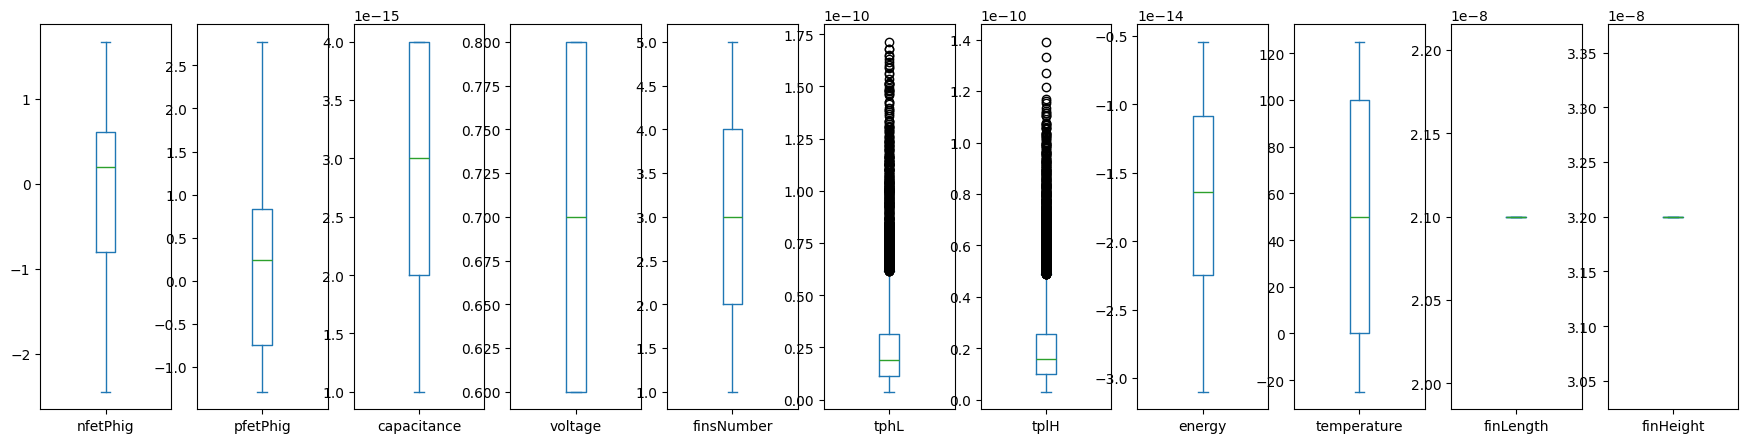

<Figure size 640x480 with 0 Axes>

In [19]:
df.plot(kind='box', figsize=(30, 5), subplots=True, layout=(1, 15))
_ = plt.figure()
plt.show()

In [20]:
df['finsNumber'].value_counts()

finsNumber
1    1664
2    1661
4    1661
3    1658
5    1652
Name: count, dtype: int64

In [21]:
df['temperature'].value_counts()

temperature
-25.0     1193
 0.0      1191
 25.0     1189
 50.0     1188
 75.0     1184
 100.0    1176
 125.0    1175
Name: count, dtype: int64

In [22]:
df.describe()

nfetPhig     pfetPhig   capacitance      voltage   finsNumber  \
count  8296.000000  8296.000000  8.296000e+03  8296.000000  8296.000000   
mean     -0.207472     0.207855  2.500723e-15     0.699301     2.997107   
std       1.042846     0.964940  1.118209e-15     0.081484     1.414040   
min      -2.450200    -1.289700  1.000000e-15     0.600000     1.000000   
25%      -0.801400    -0.744600  2.000000e-15     0.600000     2.000000   
50%       0.201400     0.245100  3.000000e-15     0.700000     3.000000   
75%       0.613100     0.836200  4.000000e-15     0.800000     4.000000   
max       1.675700     2.774200  4.000000e-15     0.800000     5.000000   

               tphL          tplH        energy  temperature     finLength  \
count  8.296000e+03  8.296000e+03  8.296000e+03  8296.000000  8.296000e+03   
mean   2.626882e-11  2.157535e-11 -1.639028e-14    49.731798  2.100000e-08   
std    2.266020e-11  1.765924e-11  7.594488e-15    49.978933  6.617844e-24   
min    3.776119e-12  3.150259e-12 -3.099975e-14   -25.000000  2.100000e-08   
25%    1.156192e-11  1.011379e-11 -2.247552e-14     0.000000  2.100000e-08   
50%    1.898482e-11  1.591842e-11 -1.641826e-14    50.000000  2.100000e-08   
75%    3.158775e-11  2.561959e-11 -1.087733e-14   100.000000  2.100000e-08   
max    1.713674e-10  1.391462e-10 -5.440730e-15   125.000000  2.100000e-08   

          finHeight  
count  8.296000e+03  
mean   3.200000e-08  
std    6.617844e-24  
min    3.200000e-08  
25%    3.200000e-08  
50%    3.200000e-08  
75%    3.200000e-08  
max    3.200000e-08

## Alterando a escala

In [23]:
from sklearn.preprocessing import MinMaxScaler
df_scaled = df.copy()
minMaxScaler = MinMaxScaler()
minMaxScaler.fit(df_scaled[["energy", "tphL", "tplH"]])

MinMaxScaler()

In [24]:
print(minMaxScaler.data_max_)
print(minMaxScaler.data_min_)

[-5.440730e-15  1.713674e-10  1.391462e-10]
[-3.099975e-14  3.776119e-12  3.150259e-12]


In [25]:
df_scaled[["energy", "tphL", "tplH"]] = minMaxScaler.transform(df_scaled[["energy", "tphL", "tplH"]])

In [26]:
results_dir = "../../Model/result/"

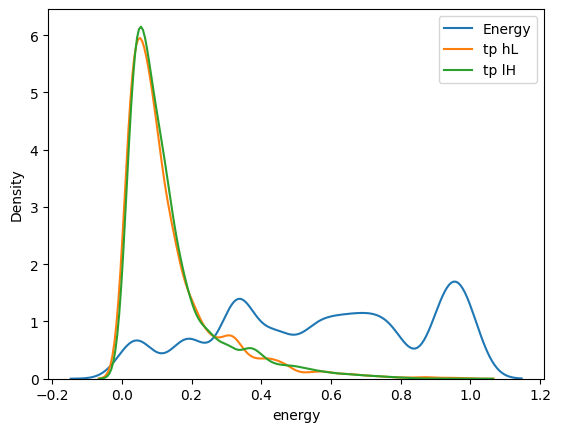

In [27]:
sns.kdeplot(df_scaled.energy, label = 'Energy')
sns.kdeplot(df_scaled.tphL, label = 'tp hL')
sns.kdeplot(df_scaled.tplH, label = 'tp lH')
plt.legend()
#plt.savefig(results_dir + 'normalized_targets.pdf') 
plt.show()

## Correlações

### Visualizações (demoram muito para rodar! >1h Cuidado)

/Users/gabriellimajacinto/Documents/Electrical-Behaviour-Prediction/.venv/lib/python3.12/site-packages/pandas/plotting/_matplotlib/misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/Users/gabriellimajacinto/Documents/Electrical-Behaviour-Prediction/.venv/lib/python3.12/site-packages/pandas/plotting/_matplotlib/misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/Users/gabriellimajacinto/Documents/Electrical-Behaviour-Prediction/.venv/lib/python3.12/site-packages/pandas/plotting/_matplotlib/misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


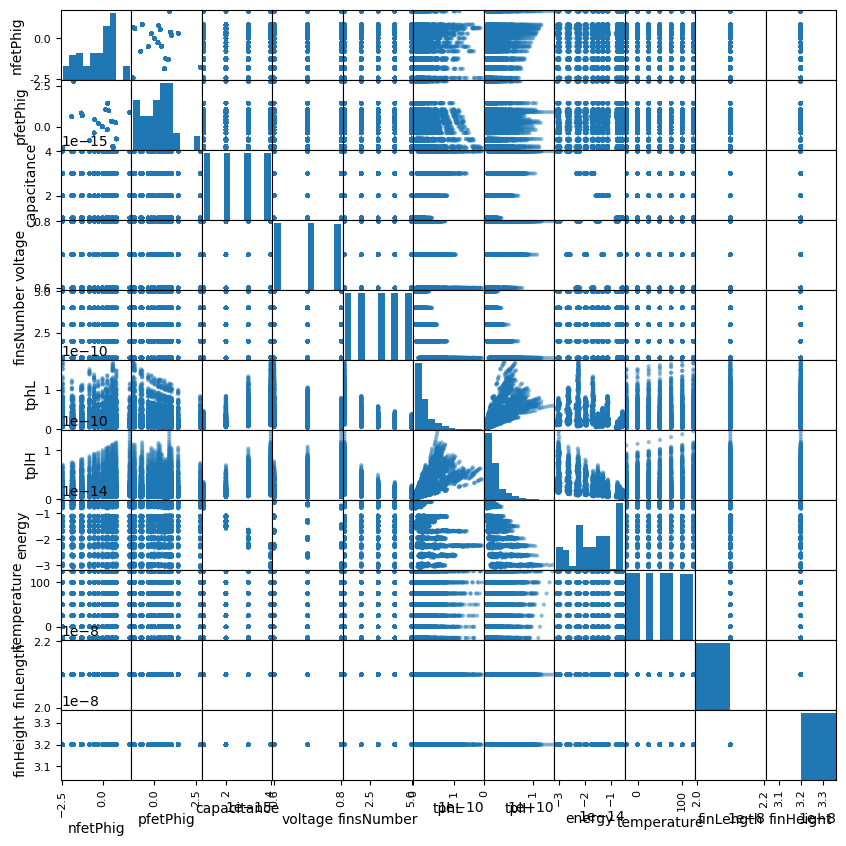

<Figure size 640x480 with 0 Axes>

In [28]:
pd.plotting.scatter_matrix(df, figsize=(10,10))
plt.figure()
plt.show()

KeyError: 'width_nmos'

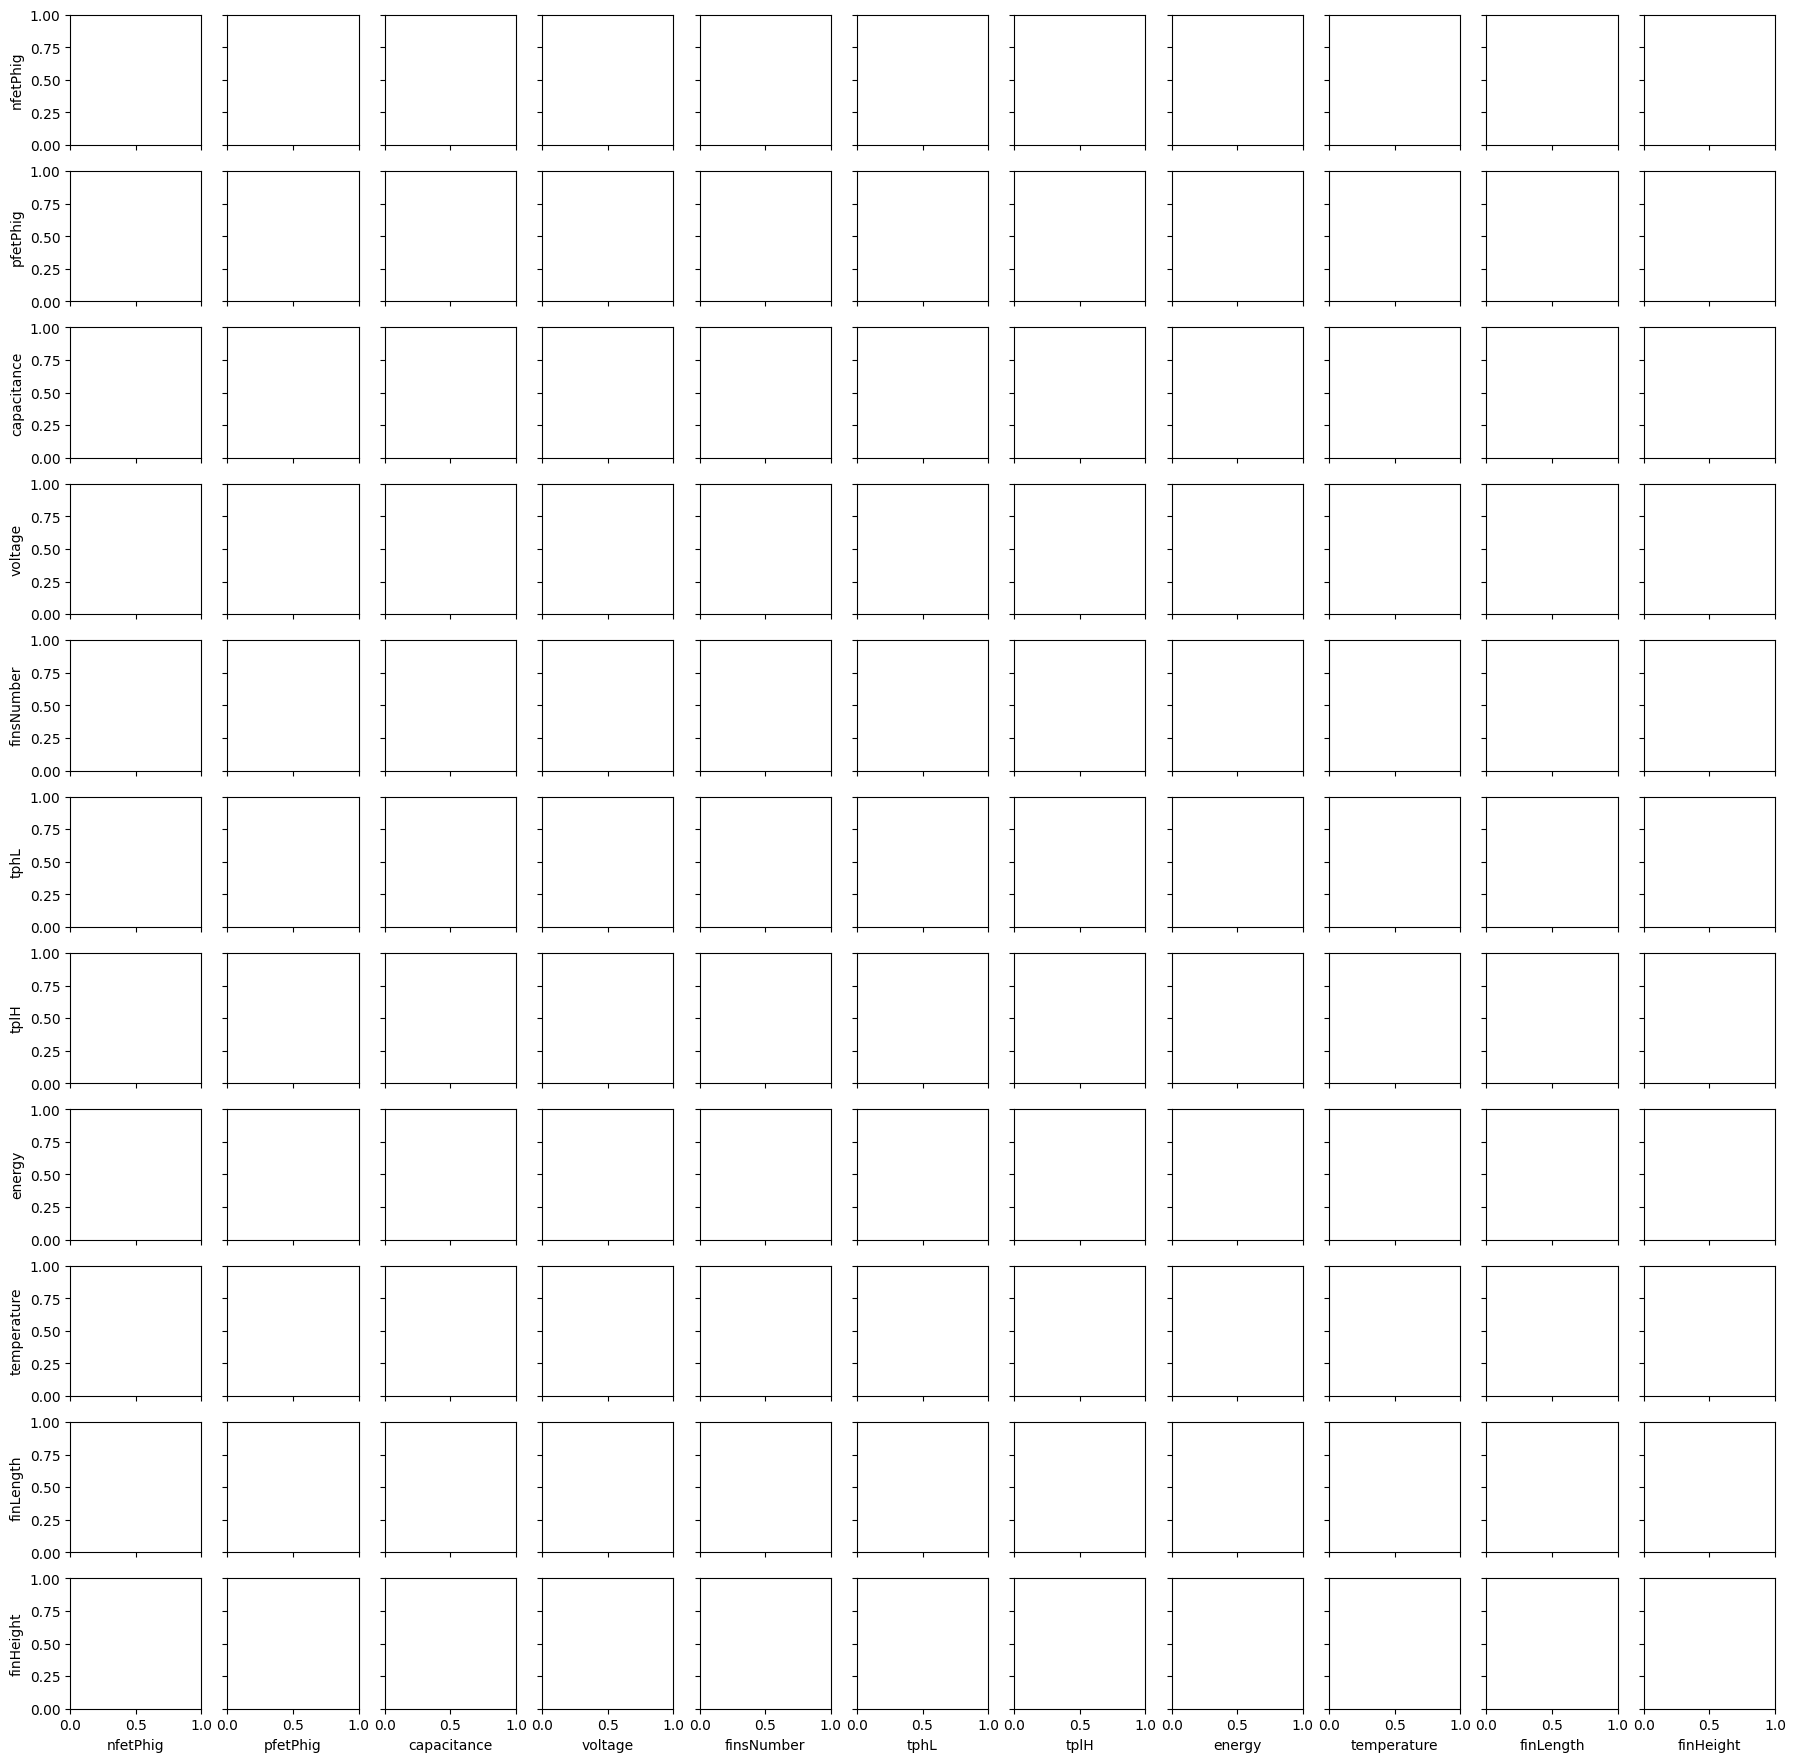

In [29]:
_ = sns.pairplot(df, hue="width_nmos", height=2, diag_kind="kde")
plt.show()

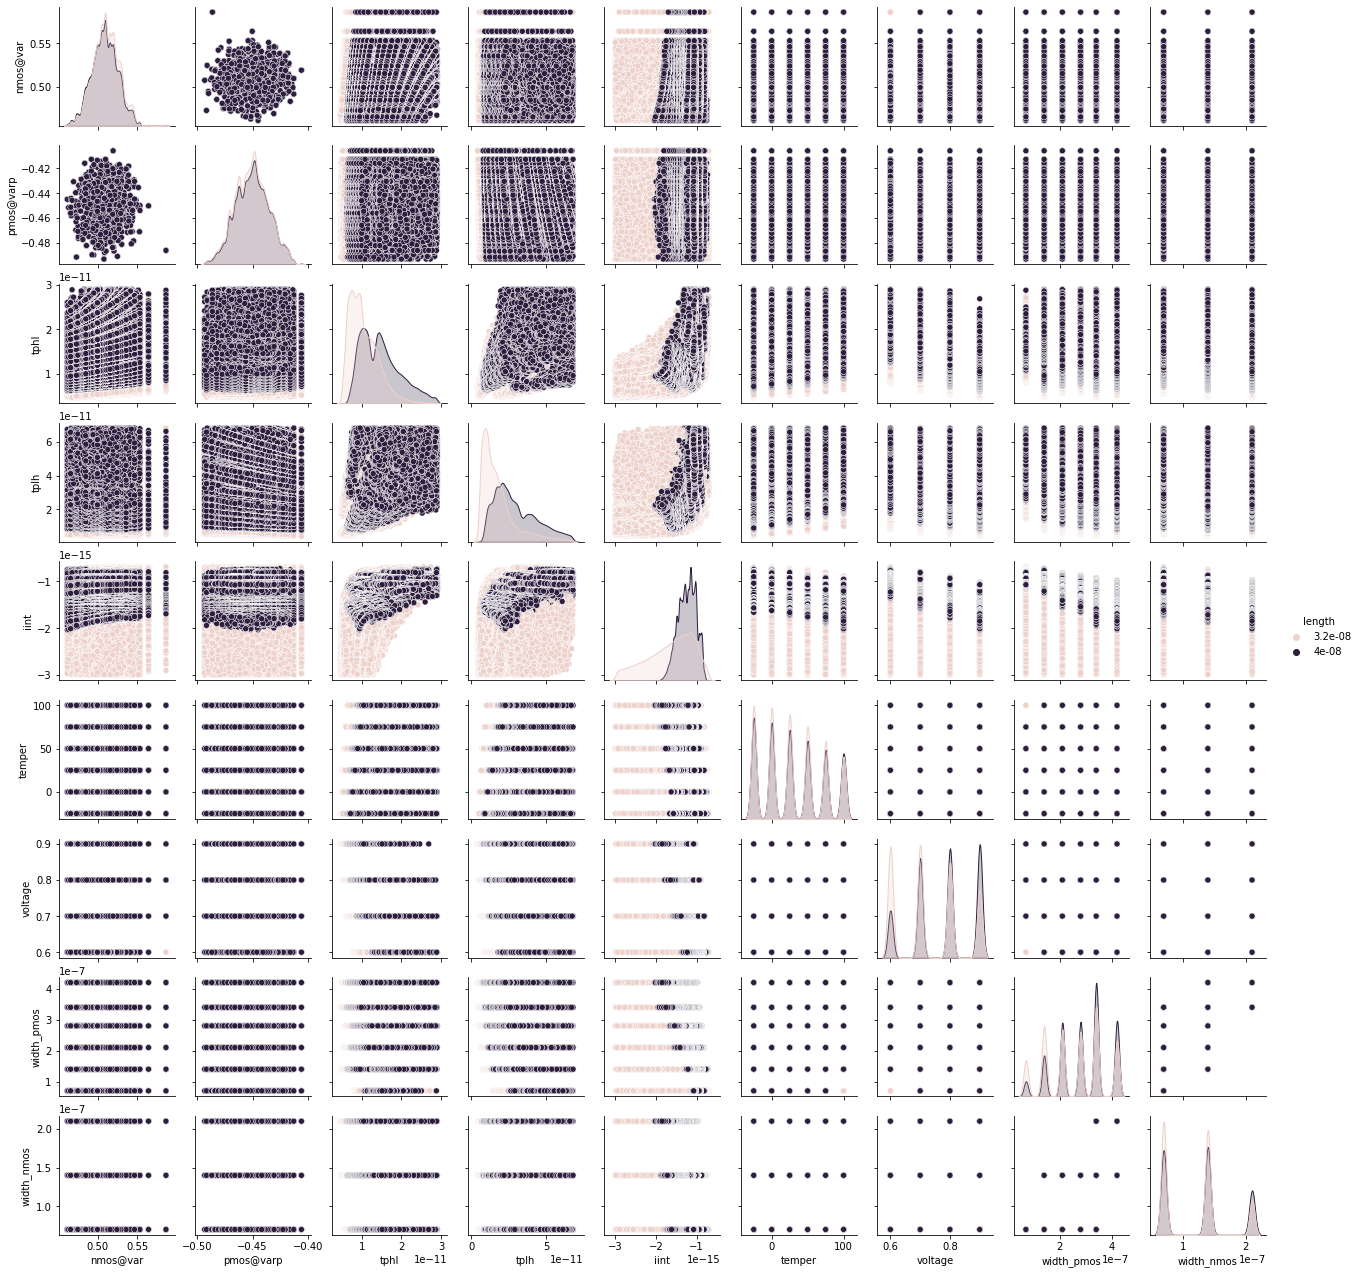

In [ ]:
_ = sns.pairplot(df, hue="length", height=2, diag_kind="kde")
plt.show()

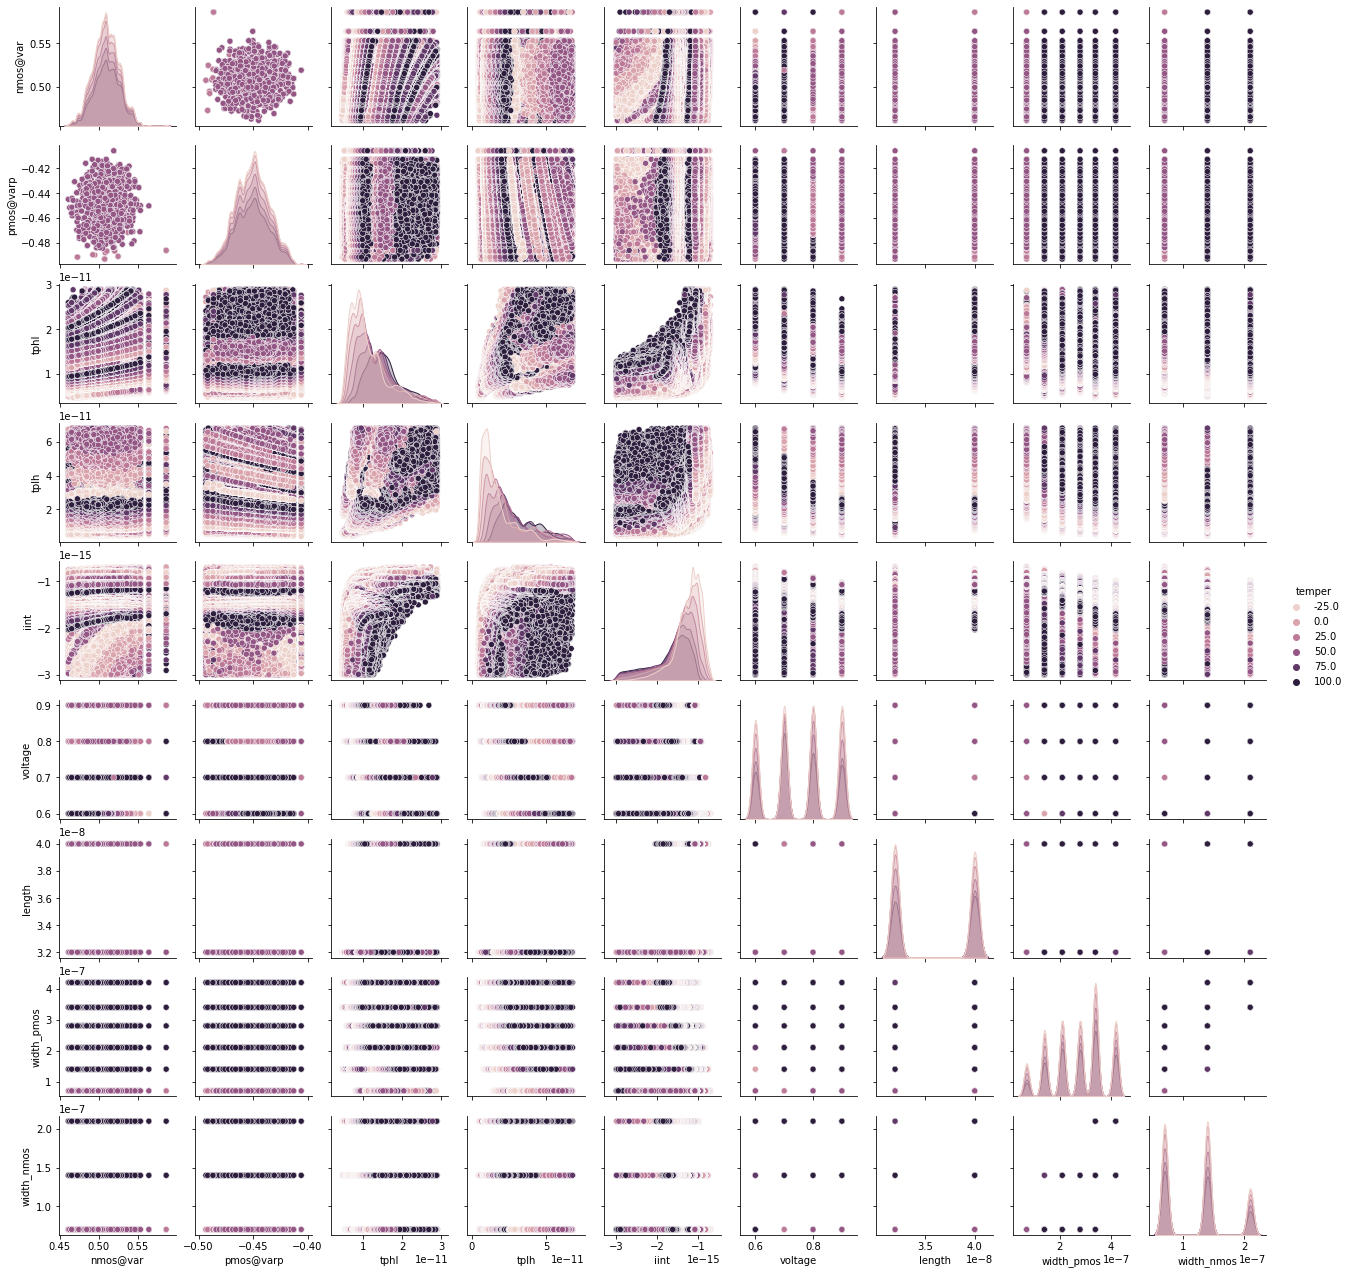

In [ ]:
_ = sns.pairplot(df, hue="temper", height=2, diag_kind="kde")
plt.show()

### Pearson

In [30]:
temp_data = df_scaled.copy()

# temp_data = temp_data.drop(columns=['tphL','tplH'])

In [31]:
temp_data

nfetPhig  pfetPhig   capacitance  voltage  finsNumber      tphL  \
case idx                                                                    
0    0      0.0000    0.0000  1.000000e-15      0.6           1  0.163791   
     1     -0.8014   -0.8294  1.000000e-15      0.6           1  0.195016   
     2     -0.2677    0.2150  1.000000e-15      0.6           1  0.157203   
     3      1.6757    0.8946  1.000000e-15      0.6           1  0.134025   
     4      0.2014    1.0447  1.000000e-15      0.6           1  0.132552   
...            ...       ...           ...      ...         ...       ...   
419  15     0.3824    0.9694  4.000000e-15      0.8           5  0.046015   
     16    -1.8849    0.6073  4.000000e-15      0.8           5  0.048095   
     17     0.8013    0.2451  4.000000e-15      0.8           5  0.050931   
     18    -1.3209    0.8362  4.000000e-15      0.8           5  0.047245   
     19    -2.4502   -1.2897  4.000000e-15      0.8           5  0.065695   

              tplH    energy  temperature     finLength     finHeight  
case idx                                                               
0    0    0.078619  0.992411         50.0  2.100000e-08  3.200000e-08  
     1    0.066047  0.991498         50.0  2.100000e-08  3.200000e-08  
     2    0.074098  0.991546         50.0  2.100000e-08  3.200000e-08  
     3    0.111133  0.997512         50.0  2.100000e-08  3.200000e-08  
     4    0.082065  0.996824         50.0  2.100000e-08  3.200000e-08  
...            ...       ...          ...           ...           ...  
419  15   0.119942  0.045323        -25.0  2.100000e-08  3.200000e-08  
     16   0.080954  0.050606        -25.0  2.100000e-08  3.200000e-08  
     17   0.127228  0.024717        -25.0  2.100000e-08  3.200000e-08  
     18   0.088561  0.054959        -25.0  2.100000e-08  3.200000e-08  
     19   0.074050  0.045934        -25.0  2.100000e-08  3.200000e-08  

[8296 rows x 11 columns]

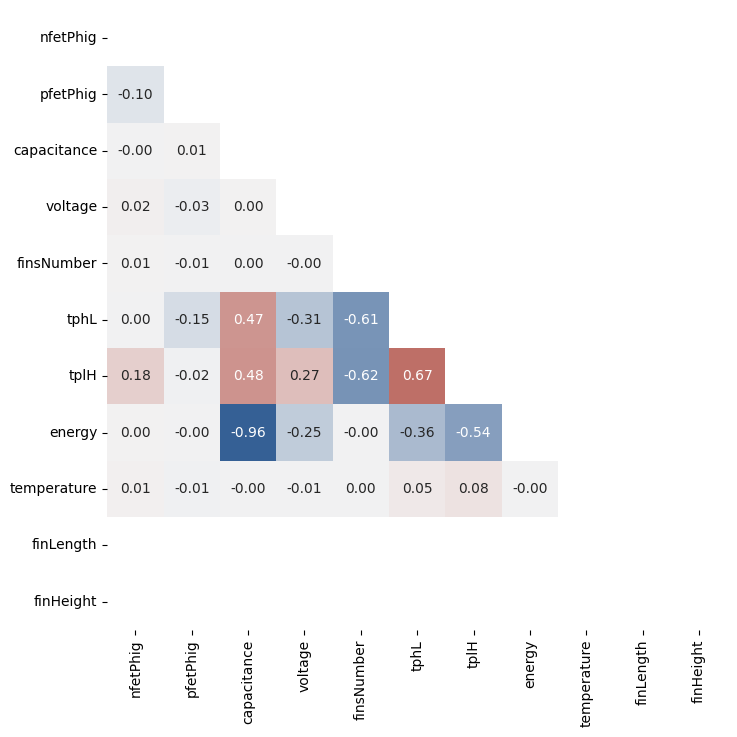

In [32]:
plt.figure(figsize=(8, 11))
mask = np.triu(np.ones_like(temp_data.corr(), dtype=bool))

# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)

sns.heatmap(temp_data.corr(), mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap=cmap, cbar=False)

plt.savefig(results_dir + 'pearson.pdf') 
plt.show()

### Kendall

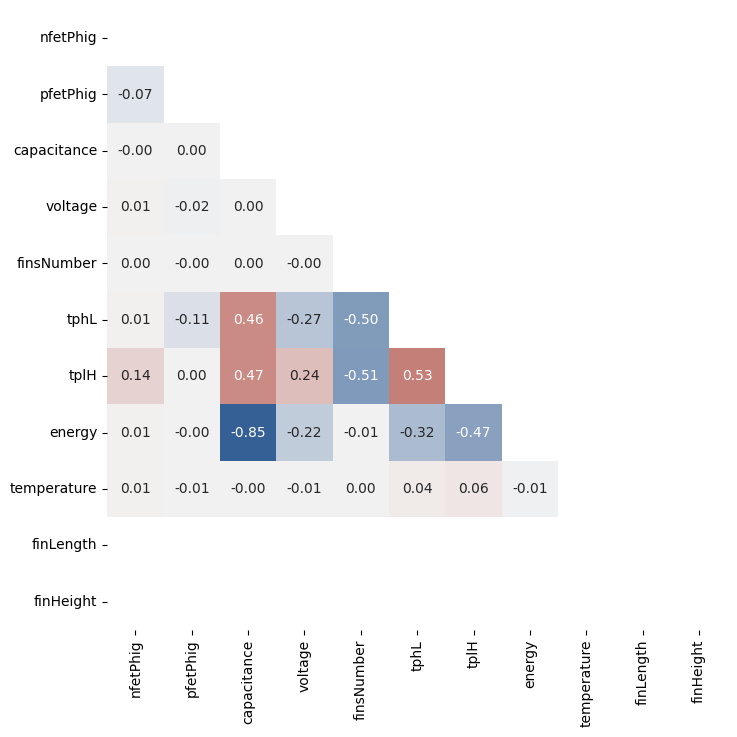

In [33]:
kendall = temp_data.corr(method='kendall')
plt.figure(figsize=(8, 11))
mask = np.triu(np.ones_like(kendall, dtype=bool))

# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)

sns.heatmap(kendall, mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap=cmap, cbar=False)
plt.savefig(results_dir + 'kendall.pdf') 

plt.show()

### Spearman

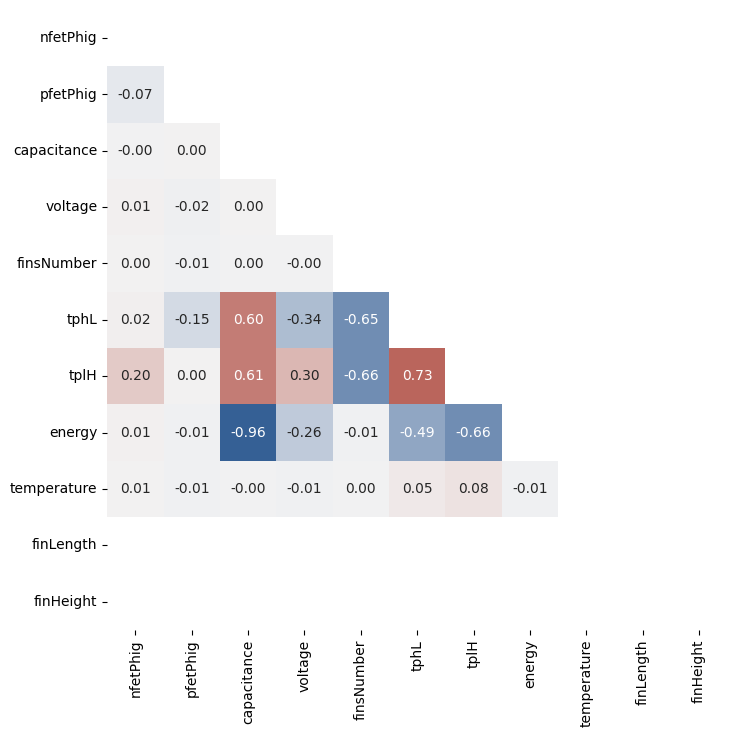

In [34]:
spearman = temp_data.corr(method='spearman')
plt.figure(figsize=(8, 11))
mask = np.triu(np.ones_like(spearman, dtype=bool))

# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)

sns.heatmap(spearman, mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap=cmap, cbar=False)
plt.savefig(results_dir + 'spearman.pdf') 

plt.show();

# Metrics

In [35]:
EPSILON = 1e-10


def _error(actual: np.ndarray, predicted: np.ndarray):
    """ Simple error """
    return actual - predicted


def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error
    Note: result is NOT multiplied by 100
    """
    return _error(actual, predicted) / (actual + EPSILON)


def _naive_forecasting(actual: np.ndarray, seasonality: int = 1):
    """ Naive forecasting method which just repeats previous samples """
    return actual[:-seasonality]


def _relative_error(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Relative Error """
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark
        return _error(actual[seasonality:], predicted[seasonality:]) /\
               (_error(actual[seasonality:], _naive_forecasting(actual, seasonality)) + EPSILON)

    return _error(actual, predicted) / (_error(actual, benchmark) + EPSILON)


def _bounded_relative_error(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Bounded Relative Error """
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark

        abs_err = np.abs(_error(actual[seasonality:], predicted[seasonality:]))
        abs_err_bench = np.abs(_error(actual[seasonality:], _naive_forecasting(actual, seasonality)))
    else:
        abs_err = np.abs(_error(actual, predicted))
        abs_err_bench = np.abs(_error(actual, benchmark))

    return abs_err / (abs_err + abs_err_bench + EPSILON)


def _geometric_mean(a, axis=0, dtype=None):
    """ Geometric mean """
    if not isinstance(a, np.ndarray):  # if not an ndarray object attempt to convert it
        log_a = np.log(np.array(a, dtype=dtype))
    elif dtype:  # Must change the default dtype allowing array type
        if isinstance(a, np.ma.MaskedArray):
            log_a = np.log(np.ma.asarray(a, dtype=dtype))
        else:
            log_a = np.log(np.asarray(a, dtype=dtype))
    else:
        log_a = np.log(a)
    return np.exp(log_a.mean(axis=axis))


def mse(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Squared Error """
    return np.mean(np.square(_error(actual, predicted)))


def rmse(actual: np.ndarray, predicted: np.ndarray):
    """ Root Mean Squared Error """
    return np.sqrt(mse(actual, predicted))


def nrmse(actual: np.ndarray, predicted: np.ndarray):
    """ Normalized Root Mean Squared Error """
    return rmse(actual, predicted) / (actual.max() - actual.min())


def me(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Error """
    return np.mean(_error(actual, predicted))


def mae(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Absolute Error """
    return np.mean(np.abs(_error(actual, predicted)))


mad = mae  # Mean Absolute Deviation (it is the same as MAE)


def gmae(actual: np.ndarray, predicted: np.ndarray):
    """ Geometric Mean Absolute Error """
    return _geometric_mean(np.abs(_error(actual, predicted)))


def mdae(actual: np.ndarray, predicted: np.ndarray):
    """ Median Absolute Error """
    return np.median(np.abs(_error(actual, predicted)))


def mpe(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Percentage Error """
    return np.mean(_percentage_error(actual, predicted))


def mape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Absolute Percentage Error
    Properties:
        + Easy to interpret
        + Scale independent
        - Biased, not symmetric
        - Undefined when actual[t] == 0
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.abs(_percentage_error(actual, predicted)))


def mdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Median Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.median(np.abs(_percentage_error(actual, predicted)))


def smape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Mean Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.mean(2.0 * np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted)) + EPSILON))


def smdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Median Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.median(2.0 * np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted)) + EPSILON))


def maape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Arctangent Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.arctan(np.abs((actual - predicted) / (actual + EPSILON))))


def mase(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """
    Mean Absolute Scaled Error
    Baseline (benchmark) is computed with naive forecasting (shifted by @seasonality)
    """
    return mae(actual, predicted) / mae(actual[seasonality:], _naive_forecasting(actual, seasonality))


def std_ae(actual: np.ndarray, predicted: np.ndarray):
    """ Normalized Absolute Error """
    __mae = mae(actual, predicted)
    return np.sqrt(np.sum(np.square(_error(actual, predicted) - __mae))/(len(actual) - 1))


def std_ape(actual: np.ndarray, predicted: np.ndarray):
    """ Normalized Absolute Percentage Error """
    __mape = mape(actual, predicted)
    return np.sqrt(np.sum(np.square(_percentage_error(actual, predicted) - __mape))/(len(actual) - 1))


def rmspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Mean Squared Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.mean(np.square(_percentage_error(actual, predicted))))


def rmdspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Median Squared Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.median(np.square(_percentage_error(actual, predicted))))


def rmsse(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """ Root Mean Squared Scaled Error """
    q = np.abs(_error(actual, predicted)) / mae(actual[seasonality:], _naive_forecasting(actual, seasonality))
    return np.sqrt(np.mean(np.square(q)))


def inrse(actual: np.ndarray, predicted: np.ndarray):
    """ Integral Normalized Root Squared Error """
    return np.sqrt(np.sum(np.square(_error(actual, predicted))) / np.sum(np.square(actual - np.mean(actual))))


def rrse(actual: np.ndarray, predicted: np.ndarray):
    """ Root Relative Squared Error """
    return np.sqrt(np.sum(np.square(actual - predicted)) / np.sum(np.square(actual - np.mean(actual))))


def mre(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Mean Relative Error """
    return np.mean(_relative_error(actual, predicted, benchmark))


def rae(actual: np.ndarray, predicted: np.ndarray):
    """ Relative Absolute Error (aka Approximation Error) """
    return np.sum(np.abs(actual - predicted)) / (np.sum(np.abs(actual - np.mean(actual))) + EPSILON)


def mrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Mean Relative Absolute Error """
    return np.mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mdrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Median Relative Absolute Error """
    return np.median(np.abs(_relative_error(actual, predicted, benchmark)))


def gmrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Geometric Mean Relative Absolute Error """
    return _geometric_mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mbrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Mean Bounded Relative Absolute Error """
    return np.mean(_bounded_relative_error(actual, predicted, benchmark))


def umbrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Unscaled Mean Bounded Relative Absolute Error """
    __mbrae = mbrae(actual, predicted, benchmark)
    return __mbrae / (1 - __mbrae)


def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))


METRICS = {
    'mse': mse,
    'rmse': rmse,
    'nrmse': nrmse,
    'me': me,
    'mae': mae,
    'mad': mad,
    'gmae': gmae,
    'mdae': mdae,
    'mpe': mpe,
    'mape': mape,
    'mdape': mdape,
    'smape': smape,
    'smdape': smdape,
    'maape': maape,
    'mase': mase,
    'std_ae': std_ae,
    'std_ape': std_ape,
    'rmspe': rmspe,
    'rmdspe': rmdspe,
    'rmsse': rmsse,
    'inrse': inrse,
    'rrse': rrse,
    'mre': mre,
    'rae': rae,
    'mrae': mrae,
    'mdrae': mdrae,
    'gmrae': gmrae,
    'mbrae': mbrae,
    'umbrae': umbrae,
    'mda': mda,
}


def evaluate(actual: np.ndarray, predicted: np.ndarray, metrics=('mae', 'mse', 'smape', 'umbrae')):
    results = {}
    for name in metrics:
        try:
            results[name] = METRICS[name](actual, predicted)
        except Exception as err:
            results[name] = np.nan
            print('Unable to compute metric {0}: {1}'.format(name, err))
    return results


def evaluate_all(actual: np.ndarray, predicted: np.ndarray):
    return evaluate(actual, predicted, metrics=set(METRICS.keys()))

In [36]:
from sklearn.preprocessing import Normalizer
def mape_normalized(actual, pred, plus_one = False):
  norm_actual = Normalizer().fit_transform(actual.reshape(-1, 1))
  norm_pred = Normalizer().fit_transform(pred.reshape(-1, 1))
  if plus_one:
    norm_actual = norm_actual + 1
    norm_pred = norm_pred + 1
  return mape(norm_actual, norm_pred)

# Train, Validation, Test Sets

Apenas testando para o Atraso de Descida

In [37]:
X = df_scaled.drop(columns=['tphL', 'tplH', 'energy'])
y = df_scaled[['tphL', 'tplH', 'energy']]

logging.info("X.shape: {}\n".format(X.shape))
logging.info("y.shape: {}\n".format(y.shape))
print(X.shape)
print(y.shape)

(8296, 8)
(8296, 3)


In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

seed = 23

Xtr, Xte, ytr, yte = train_test_split(X, y, random_state=seed, test_size=0.25)

# grellert esse é o mais recomendado
scaler = StandardScaler().fit(Xtr)
Xtr_sc = scaler.transform(Xtr)
Xte_sc = scaler.transform(Xte)

X_train, X_val, y_train, y_val = train_test_split(Xtr_sc, ytr, random_state=seed, test_size=0.33)

logging.info("Test set X {}\n".format(Xte.shape))
logging.info("Test set y {}\n".format(yte.shape))
logging.info("Train set X {}\n".format(X_train.shape))
logging.info("Train set y {}\n".format(y_train.shape))
logging.info("Validation set X {}\n".format(X_val.shape))
logging.info("Validation set y {}\n".format(y_val.shape))

print("Test set X", Xte.shape)
print("Test set y", yte.shape)
print("Train set X", X_train.shape)
print("Train set y", y_train.shape)
print("Validation set X", X_val.shape)
print("Validation set y", y_val.shape)

Test set X (2074, 8)
Test set y (2074, 3)
Train set X (4168, 8)
Train set y (4168, 3)
Validation set X (2054, 8)
Validation set y (2054, 3)


In [39]:
y_train.describe()

tphL         tplH       energy
count  4168.000000  4168.000000  4168.000000
mean      0.130615     0.135121     0.578447
std       0.132389     0.131942     0.296255
min       0.000492     0.001980     0.000000
25%       0.043957     0.049425     0.334263
50%       0.086468     0.091688     0.619403
75%       0.162345     0.163966     0.906050
max       1.000000     0.955405     0.999915

# New Models


In [40]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from math import sqrt

## Shortlisting

In [41]:
clfs = [RandomForestRegressor(), LinearRegression(), SVR(kernel='rbf'), DecisionTreeRegressor()]

label: TPHL
clf: RandomForestRegressor, mse: 3.7784458931535836e-05, rmse: 0.006146906452154273, r2: 0.997920232899437
clf: LinearRegression, mse: 0.004946431239947841, rmse: 0.07033086975111172, r2: 0.7277339612913096
clf: SVR, mse: 0.002359701592081698, rmse: 0.04857675979397656, r2: 0.8701151246534969
clf: DecisionTreeRegressor, mse: 7.30979514050492e-05, rmse: 0.008549733996157377, r2: 0.9959764750177781
label: TPLH
clf: RandomForestRegressor, mse: 3.5526315308540337e-05, rmse: 0.0059603955664486175, r2: 0.9977695367350122
clf: LinearRegression, mse: 0.004366479608437856, rmse: 0.06607934328092142, r2: 0.725857514933517
clf: SVR, mse: 0.0030155081060025696, rmse: 0.0549136422576628, r2: 0.8106761143873934
clf: DecisionTreeRegressor, mse: 6.968763896330316e-05, rmse: 0.008347912251773084, r2: 0.9956247723024062


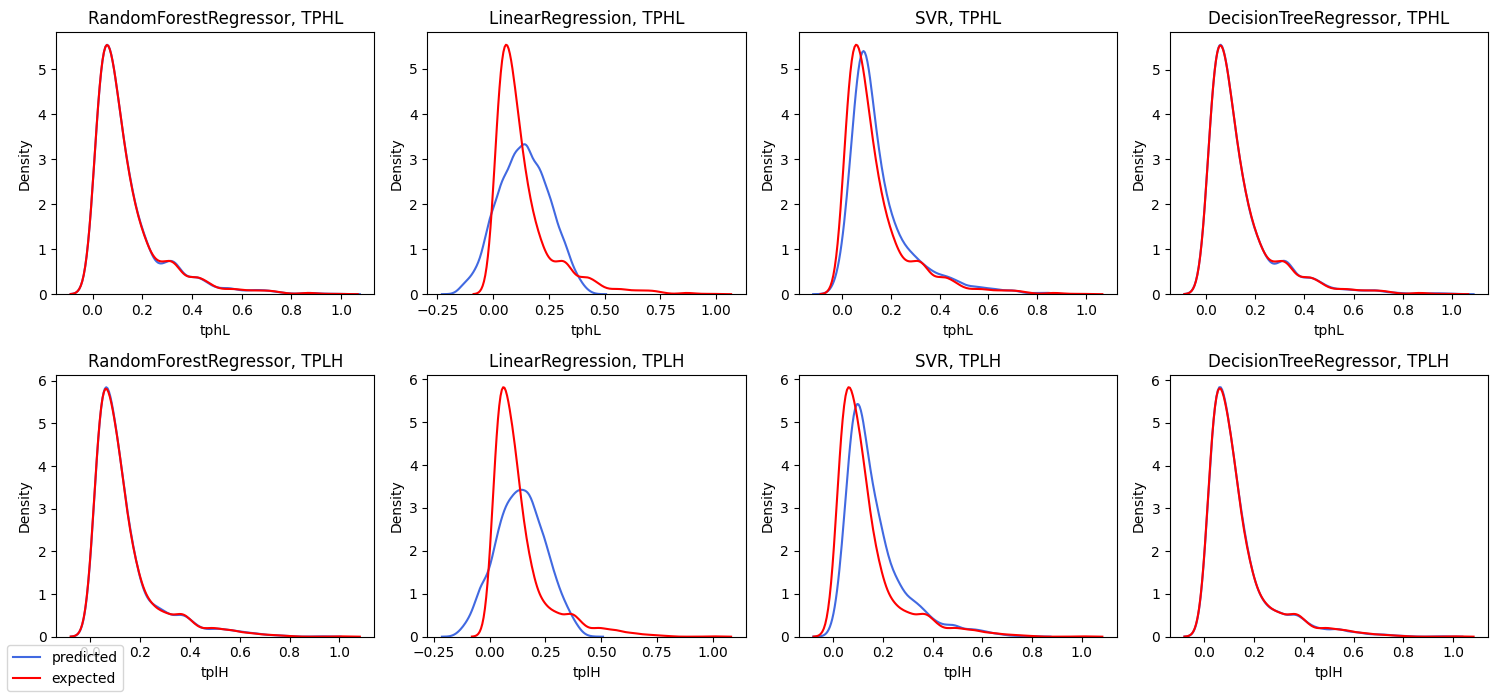

In [42]:
fig, ax = plt.subplots(2,4, figsize = (15,7))
#modelos para TPHL
print('label: TPHL')
logging.info('label: TPHL')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.tphL)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tphL, ypred)
    r2 = r2_score(y_val.tphL, ypred)
    mape_v0 = mape(y_val.tphL+1, ypred+1)
    #mape_v1 = mape_normalized(np.array(y_val.tphLa), ypred)
    #mape_v2 = mape_normalized(np.array(y_val.tphLa), ypred, True)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, rmse: {sqrt(mse)}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[0][i],color = 'royalblue')
    sns.kdeplot(data=y_val.tphL, label = 'true', ax = ax[0][i], color = 'red')
    ax[0][i].set_title(f'{clf.__class__.__name__}, TPHL')

#modelos para TPLH
print('label: TPLH')
logging.info('label: TPLH')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.tplH)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tplH, ypred)
    r2 = r2_score(y_val.tplH, ypred)
    mape_v0 = mape(y_val.tplH+1, ypred+1)
    #mape_v1 = mape_normalized(np.array(y_val.tplha), ypred)
    #mape_v2 = mape_normalized(np.array(y_val.tplha), ypred, True)
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, rmse: {sqrt(mse)}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[1][i],color = 'royalblue')
    sns.kdeplot(data=y_val.tplH, label = 'true', ax = ax[1][i], color = 'red')
    ax[1][i].set_title(f'{clf.__class__.__name__}, TPLH')

plt.tight_layout()
fig.legend(labels=["predicted", "expected"], loc='lower left')
plt.savefig(results_dir + 'delays_nand2.pdf') 
plt.show()

label: TPHL
clf: RandomForestRegressor, mse: 3.826048577750738e-05, r2: 0.9978940309899421
clf: LinearRegression, mse: 0.004946431239947841, r2: 0.7277339612913096
clf: SVR, mse: 0.002359701592081698, r2: 0.8701151246534969
clf: DecisionTreeRegressor, mse: 7.47787720514098e-05, r2: 0.9958839577347178


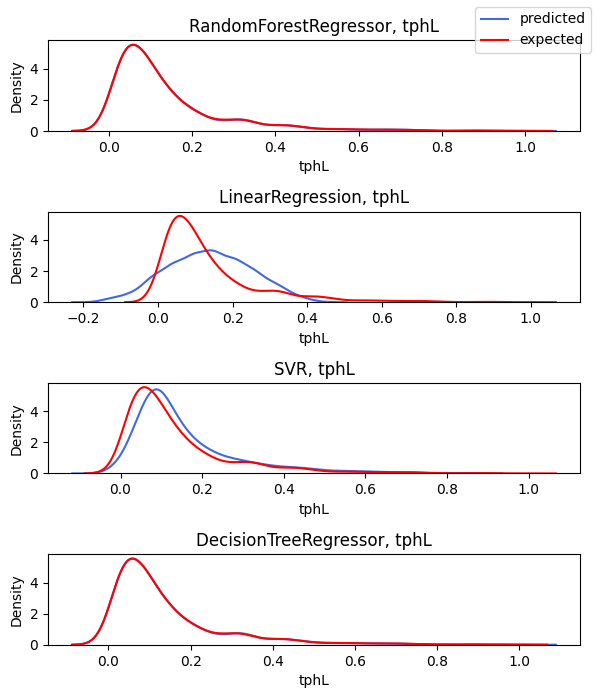

In [43]:
fig, ax = plt.subplots(4,1, figsize = (6,7))
pred_TPHLA = {}

#modelos para TPHL
print('label: TPHL')
logging.info('label: TPHL')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.tphL)
    pred_TPHLA['{}'.format(clf.__class__.__name__)] = clf
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tphL, ypred)
    r2 = r2_score(y_val.tphL, ypred)
    mape_v0 = mape(y_val.tphL+1, ypred+1)
    #mape_v1 = mape_normalized(np.array(y_val.tphLa), ypred)
    #mape_v2 = mape_normalized(np.array(y_val.tphLa), ypred, True)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[i],color = 'royalblue')
    sns.kdeplot(data=y_val.tphL, label = 'true', ax = ax[i], color = 'red')
    ax[i].set_title(f'{clf.__class__.__name__}, tphL')
    

plt.tight_layout()
fig.legend(labels=["predicted", "expected"])
plt.savefig(results_dir + 'tphL_nand.pdf') 
#plt.xlim([-0.05, 0.5])
plt.show()

label: TPLH
clf: RandomForestRegressor, mse: 3.46009071282034e-05, r2: 0.9978276370173926
clf: LinearRegression, mse: 0.004366479608437856, r2: 0.725857514933517
clf: SVR, mse: 0.0030155081060025696, r2: 0.8106761143873934
clf: DecisionTreeRegressor, mse: 6.734474228796219e-05, r2: 0.9957718673479414


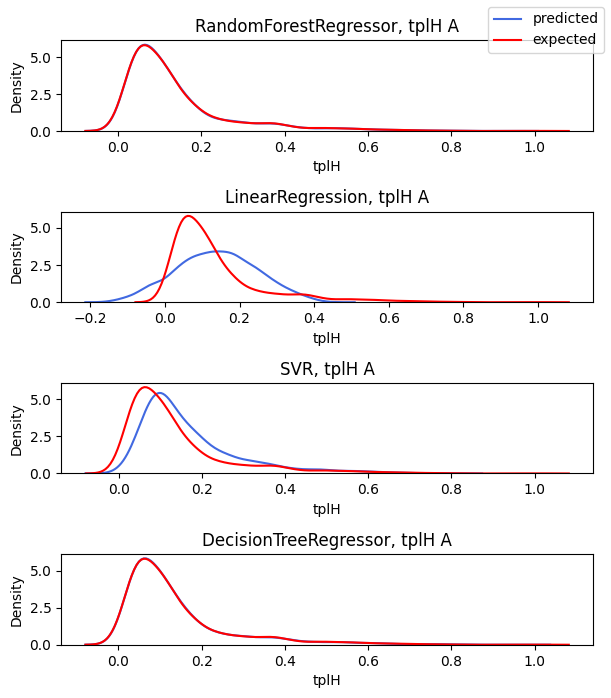

In [44]:
fig, ax = plt.subplots(4,1, figsize = (6,7))
pred_TPLH = {}
#modelos para TPLH
print('label: TPLH')
logging.info('label: TPLH')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.tplH)
    pred_TPLH['{}'.format(clf.__class__.__name__)] = clf
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tplH, ypred)
    r2 = r2_score(y_val.tplH, ypred)
    mape_v0 = mape(y_val.tplH+1, ypred+1)
    #mape_v1 = mape_normalized(np.array(y_val.tplHa), ypred)
    #mape_v2 = mape_normalized(np.array(y_val.tplHa), ypred, True)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[i],color = 'royalblue')
    sns.kdeplot(data=y_val.tplH, label = 'true', ax = ax[i], color = 'red')
    ax[i].set_title(f'{clf.__class__.__name__}, tplH A')
    ax[i].set(xlabel='tplH')
plt.tight_layout()
fig.legend(labels=["predicted", "expected"])
plt.savefig(results_dir + 'tplH_nand.pdf') 
plt.show()

label: IINT
clf: RandomForestRegressor, mse: 3.570508439143572e-05, r2: 0.9995940215810208
clf: LinearRegression, mse: 0.0011290552906738948, r2: 0.9871622742345968
clf: SVR, mse: 0.0021983950637110474, r2: 0.9750035333211241
clf: DecisionTreeRegressor, mse: 5.9707959861233197e-05, r2: 0.9993211010824344


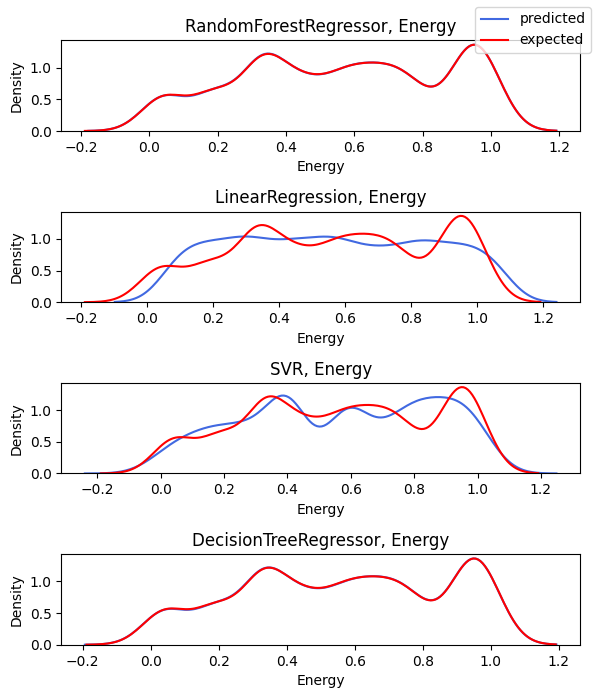

In [45]:
fig, ax = plt.subplots(4,1, figsize = (6,7))
pred_IINT = {}
print('label: IINT')
logging.info('label: IINT')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.energy)
    pred_IINT['{}'.format(clf.__class__.__name__)] = clf
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.energy, ypred)
    r2 = r2_score(y_val.energy, ypred)
    mape_v0 = mape(y_val.energy+1, ypred+1)
    #mape_v1 = mape_normalized(np.array(y_val.iint), ypred)
    #mape_v2 = mape_normalized(np.array(y_val.iint), ypred, True)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[i],color = 'royalblue')
    sns.kdeplot(data=y_val.energy, label = 'true', ax = ax[i], color = 'red')
    ax[i].set_title(f'{clf.__class__.__name__}, Energy')
    ax[i].set(xlabel='Energy')
plt.tight_layout()
fig.legend(labels=["predicted", "expected"])
plt.savefig(results_dir + 'energy_nand.pdf')
plt.show()

label: IINT
clf: RandomForestRegressor, mse: 3.592448443362193e-05, r2: 0.9995915269312037
clf: LinearRegression, mse: 0.0011290552906738948, r2: 0.9871622742345968
clf: SVR, mse: 0.0021983950637110474, r2: 0.9750035333211241
clf: DecisionTreeRegressor, mse: 5.983440227250739e-05, r2: 0.9993196633911057


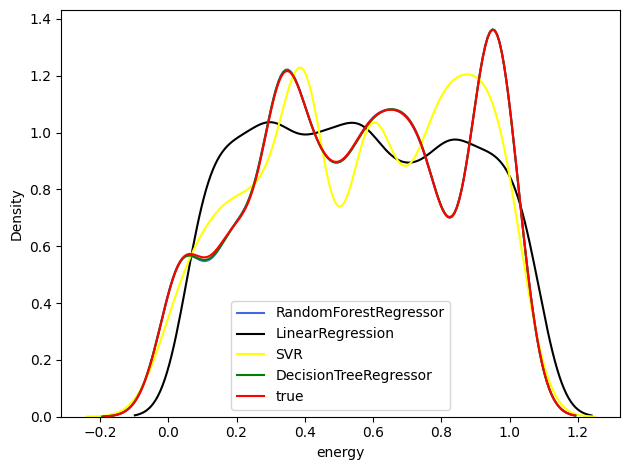

In [46]:
#fig, ax = plt.subplots(4,1, figsize = (6,7))
pred_IINT = {}
colors_opt = {'RandomForestRegressor': 'royalblue', 'LinearRegression': 'black', 'SVR': 'yellow', 'DecisionTreeRegressor': 'green'}
print('label: IINT')
logging.info('label: IINT')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.energy)
    pred_IINT['{}'.format(clf.__class__.__name__)] = clf
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.energy, ypred)
    r2 = r2_score(y_val.energy, ypred)
    mape_v0 = mape(y_val.energy+1, ypred+1)
    #mape_v1 = mape_normalized(np.array(y_val.iint), ypred)
    #mape_v2 = mape_normalized(np.array(y_val.iint), ypred, True)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = f'{clf.__class__.__name__}', color = colors_opt[f'{clf.__class__.__name__}'])

sns.kdeplot(data=y_val.energy, label = 'true', color = 'red')
plt.tight_layout()
plt.legend()
plt.savefig(results_dir + 'energy_nand.pdf')
plt.show()

# Inferencia Time

In [47]:
import time

In [48]:
test_case = X_val[1,:]

In [49]:
#def pred_time(clfs: dict, value: np.array): -> List

##TPLH
print("\n TPLH")
logging.info("\n TPLH")
for k in pred_TPLH.values():
  start_time = time.time()
  k_pred = k.predict(test_case.reshape(1, -1))
  finish_time = time.time() - start_time
  print("{}: {:.5f} secs".format(k, finish_time))
  logging.info("{}: {} secs".format(k, finish_time))


##IINT
print("\n IINT")
logging.info("\n IINT")
for b in pred_IINT.values():
  start_time = time.time()
  b_pred = b.predict(test_case.reshape(1, -1))
  finish_time = time.time() - start_time
  print("{}: {:.5f} secs".format(b.__class__.__name__, finish_time))
  logging.info("{}: {} secs".format(b.__class__.__name__, finish_time))

  
##TPHL
print("\n TPHL")
for a in pred_TPHLA.values():
  start_time = time.time()
  a_pred = a.predict(test_case.reshape(1, -1))
  print("{}: {} secs".format(a.__class__.__name__, time.time() - start_time))


 TPLH
RandomForestRegressor(): 0.00282 secs
LinearRegression(): 0.00009 secs
SVR(): 0.00009 secs
DecisionTreeRegressor(): 0.00006 secs

 IINT
RandomForestRegressor: 0.00228 secs
LinearRegression: 0.00009 secs
SVR: 0.00009 secs
DecisionTreeRegressor: 0.00006 secs

 TPHL
RandomForestRegressor: 0.0013933181762695312 secs
LinearRegression: 3.695487976074219e-05 secs
SVR: 5.507469177246094e-05 secs
DecisionTreeRegressor: 3.5762786865234375e-05 secs


# Fine-tuning

### MLR

label: TPHL
clf: LinearRegression, mse: 0.004946431239947841, r2: 0.7277339612913096
label: TPLH
clf: LinearRegression, mse: 0.004366479608437856, r2: 0.725857514933517
label: IINT
clf: LinearRegression, mse: 0.0011290552906738948, r2: 0.9871622742345968


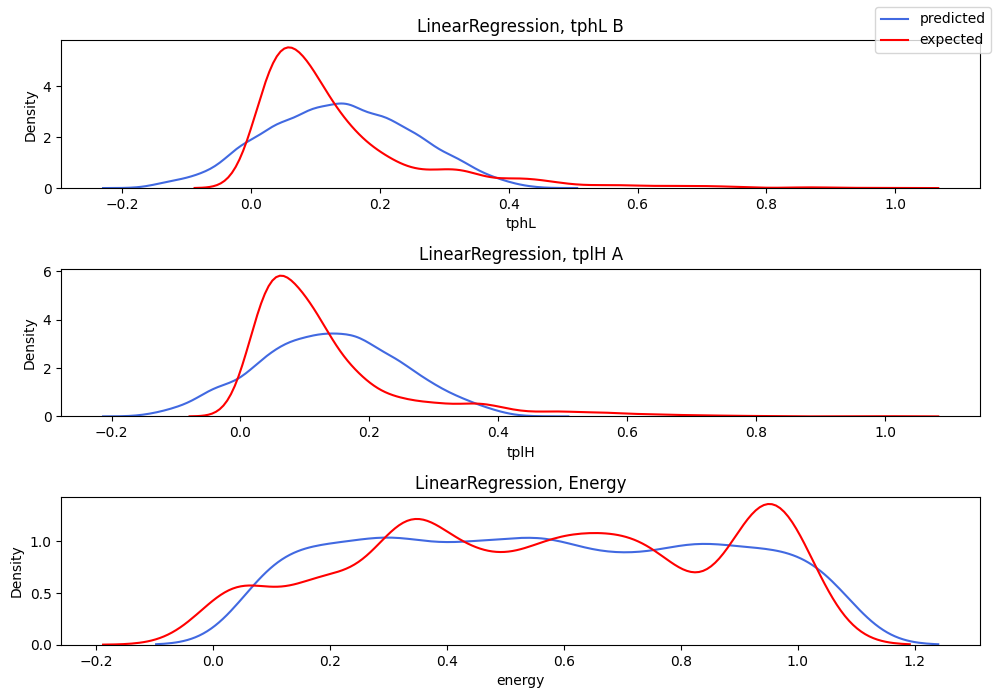

In [50]:
clfs = [LinearRegression()]
fig, ax = plt.subplots(3,1, figsize = (10,7))
logging.info("==== results_cv ====")

#modelos para TPHL
print('label: TPHL')
logging.info('label: TPHL')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.tphL)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tphL, ypred)
    r2 = r2_score(y_val.tphL, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[0],color = 'royalblue')
    sns.kdeplot(data=y_val.tphL, label = 'true', ax = ax[0], color = 'red')
    ax[0].set_title(f'{clf.__class__.__name__}, tphL B')

#modelos para TPLH
print('label: TPLH')
logging.info('label: TPLH')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.tplH)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tplH, ypred)
    r2 = r2_score(y_val.tplH, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[1],color = 'royalblue')
    sns.kdeplot(data=y_val.tplH, label = 'true', ax = ax[1], color = 'red')
    ax[1].set_title(f'{clf.__class__.__name__}, tplH A')

#modelos para IINT
print('label: IINT')
logging.info('label: IINT')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.energy)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.energy, ypred)
    r2 = r2_score(y_val.energy, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2} (max_depth = 4)')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[2],color = 'royalblue')
    sns.kdeplot(data=y_val.energy, label = 'true', ax = ax[2], color = 'red')
    ax[2].set_title(f'{clf.__class__.__name__}, Energy')

plt.tight_layout()
fig.legend(labels=["predicted", "expected"])
plt.savefig(results_dir + 'RF_all_best_hyperparams_nand.pdf')
plt.show()

In [51]:
from math import sqrt

print(f"tphl = {sqrt(0.004946431239947841)}, tplh = {sqrt(0.004366479608437856)}, energy = {sqrt(0.0011290552906738948)}")

tphl = 0.07033086975111172, tplh = 0.06607934328092142, energy = 0.03360141798605968


### Decision Tree

In [52]:
params = {'max_depth': [1, 2, 4, 8, 16, 32, 64, 128]}
          #'max_features': [2, 5, 7],
          #'min_samples_split': [2, 8, 15, 30],}

DF_model_cv_gs = DecisionTreeRegressor(random_state=seed)

# criando o objeto do grid search com GridSearchCV
grid_search = GridSearchCV(DF_model_cv_gs, param_grid=params, scoring= "r2",return_train_score=True, cv =10) # valor padrão para quebras é 3
logging.info("\n ==== hyperparameters (cv = 10)====")

##### TPHL ####
grid_search.fit(Xtr, ytr.tphL)
print('\n Best hyperparameters:')
logging.info('\n Best hyperparameters:')
print(grid_search.best_params_)
logging.info(grid_search.best_params_)
DF_cv_results_TPHL = pd.DataFrame(grid_search.cv_results_)
print("Average Score on train set: {:.3f} +/- {:.3f}".format(DF_cv_results_TPHL[DF_cv_results_TPHL.rank_test_score == 1].mean_train_score.values[0],
                                                                     DF_cv_results_TPHL[DF_cv_results_TPHL.rank_test_score == 1].std_train_score.values[0]))
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(DF_cv_results_TPHL[DF_cv_results_TPHL.rank_test_score == 1].mean_test_score.values[0],
                                                                     DF_cv_results_TPHL[DF_cv_results_TPHL.rank_test_score == 1].std_test_score.values[0]))
logging.info("Average Score on train set: {:.3f} +/- {:.3f}".format(DF_cv_results_TPHL[DF_cv_results_TPHL.rank_test_score == 1].mean_train_score.values[0],
                                                                     DF_cv_results_TPHL[DF_cv_results_TPHL.rank_test_score == 1].std_train_score.values[0]))
logging.info("Average Score on validation set: {:.3f} +/- {:.3f}".format(DF_cv_results_TPHL[DF_cv_results_TPHL.rank_test_score == 1].mean_test_score.values[0],
                                                                     DF_cv_results_TPHL[DF_cv_results_TPHL.rank_test_score == 1].std_test_score.values[0]))

#### TPLH ####
grid_search.fit(Xtr, ytr.tplH)
print('\n Best hyperparameters:')
logging.info('\n Best hyperparameters:')
print(grid_search.best_params_)
logging.info(grid_search.best_params_)
DF_cv_results_TPLH = pd.DataFrame(grid_search.cv_results_)
print("Average Score on train set: {:.3f} +/- {:.3f}".format(DF_cv_results_TPLH[DF_cv_results_TPLH.rank_test_score == 1].mean_train_score.values[0],
                                                                     DF_cv_results_TPLH[DF_cv_results_TPLH.rank_test_score == 1].std_train_score.values[0]))
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(DF_cv_results_TPLH[DF_cv_results_TPLH.rank_test_score == 1].mean_test_score.values[0],
                                                                     DF_cv_results_TPLH[DF_cv_results_TPLH.rank_test_score == 1].std_test_score.values[0]))
logging.info("Average Score on train set: {:.3f} +/- {:.3f}".format(DF_cv_results_TPLH[DF_cv_results_TPLH.rank_test_score == 1].mean_train_score.values[0],
                                                                     DF_cv_results_TPLH[DF_cv_results_TPLH.rank_test_score == 1].std_train_score.values[0]))
logging.info("Average Score on validation set: {:.3f} +/- {:.3f}".format(DF_cv_results_TPLH[DF_cv_results_TPLH.rank_test_score == 1].mean_test_score.values[0],
                                                                     DF_cv_results_TPLH[DF_cv_results_TPLH.rank_test_score == 1].std_test_score.values[0]))


#### IINT ####
grid_search.fit(Xtr, ytr.energy)
print('\n Best hyperparameters (Energy):')
logging.info('\n Best hyperparameters:')
print(grid_search.best_params_)
logging.info(grid_search.best_params_)
DF_cv_results_iint = pd.DataFrame(grid_search.cv_results_)
print("Average Score on train set: {:.3f} +/- {:.3f}".format(DF_cv_results_iint[DF_cv_results_iint.rank_test_score == 1].mean_train_score.values[0],
                                                                     DF_cv_results_iint[DF_cv_results_iint.rank_test_score == 1].std_train_score.values[0]))
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(DF_cv_results_iint[DF_cv_results_iint.rank_test_score == 1].mean_test_score.values[0],
                                                                     DF_cv_results_iint[DF_cv_results_iint.rank_test_score == 1].std_test_score.values[0]))
logging.info("Average Score on train set: {:.3f} +/- {:.3f}".format(DF_cv_results_iint[DF_cv_results_iint.rank_test_score == 1].mean_train_score.values[0],
                                                                     DF_cv_results_iint[DF_cv_results_iint.rank_test_score == 1].std_train_score.values[0]))
logging.info("Average Score on validation set: {:.3f} +/- {:.3f}".format(DF_cv_results_iint[DF_cv_results_iint.rank_test_score == 1].mean_test_score.values[0],
                                                                     DF_cv_results_iint[DF_cv_results_iint.rank_test_score == 1].std_test_score.values[0]))


 Best hyperparameters:
{'max_depth': 4}
Average Score on train set: 0.624 +/- 0.003
Average Score on validation set: 0.606 +/- 0.030

 Best hyperparameters:
{'max_depth': 4}
Average Score on train set: 0.605 +/- 0.004
Average Score on validation set: 0.575 +/- 0.039

 Best hyperparameters (Energy):
{'max_depth': 2}
Average Score on train set: 0.062 +/- 0.002
Average Score on validation set: 0.060 +/- 0.015


label: TPHL
clf: DecisionTreeRegressor, mse: 0.0020712967140961076, r2: 0.8859897724276825
label: TPLH
clf: DecisionTreeRegressor, mse: 0.0013754971704994527, r2: 0.9136415954413354
label: IINT
clf: DecisionTreeRegressor, mse: 5.5966508164964886e-05, r2: 0.9993636426047477


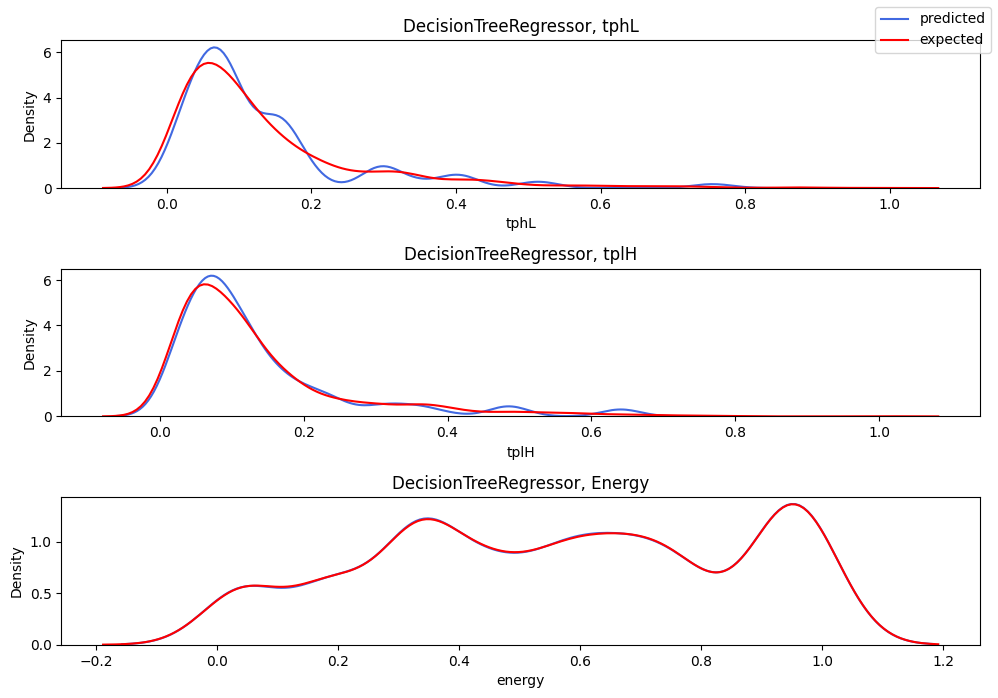

In [53]:
clfs = [DecisionTreeRegressor(random_state = seed)]
fig, ax = plt.subplots(3,1, figsize = (10,7))

logging.info("==== results_cv ====")

#modelos para TPHL
print('label: TPHL')
logging.info('label: TPHL')
for idx,clf in enumerate(clfs):
    i = idx
    clf.set_params(max_depth = 4)
    clf = clf.fit(X_train, y_train.tphL)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tphL, ypred)
    r2 = r2_score(y_val.tphL, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[0],color = 'royalblue')
    sns.kdeplot(data=y_val.tphL, label = 'true', ax = ax[0], color = 'red')
    ax[0].set_title(f'{clf.__class__.__name__}, tphL')

#modelos para TPLH
print('label: TPLH')
logging.info('label: TPLH')
for idx,clf in enumerate(clfs):
    i = idx
    clf.set_params(max_depth = 5)
    clf = clf.fit(X_train, y_train.tplH)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tplH, ypred)
    r2 = r2_score(y_val.tplH, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[1],color = 'royalblue')
    sns.kdeplot(data=y_val.tplH, label = 'true', ax = ax[1], color = 'red')
    ax[1].set_title(f'{clf.__class__.__name__}, tplH')

#modelos para IINT
print('label: IINT')
logging.info('label: IINT')
for idx,clf in enumerate(clfs):
    i = idx
    clf.set_params(max_depth = 4)
    clf = clf.fit(X_train, y_train.energy)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.energy, ypred)
    r2 = r2_score(y_val.energy, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2} (max_depth = 4)')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[2],color = 'royalblue')
    sns.kdeplot(data=y_val.energy, label = 'true', ax = ax[2], color = 'red')
    ax[2].set_title(f'{clf.__class__.__name__}, Energy')

plt.tight_layout()
fig.legend(labels=["predicted", "expected"])
plt.savefig(results_dir + 'DT_all_best_hyperparams_nand.pdf')
plt.show()


In [54]:
print(f"tphl = {sqrt(0.0020712967140961076)}, tplh = {sqrt(0.0013754971704994527)}, energy = {sqrt(5.5966508164964886e-05)}")

tphl = 0.045511500899180504, tplh = 0.03708769567524319, energy = 0.007481076671506909


### Random Forest

In [55]:
params = {'n_estimators': [1, 2, 3, 4, 5, 50, 75, 85, 95, 100],
          'max_depth': [1, 2, 4, 8, 16, 32, 64, 128]}
          #'max_features': [2, 5, 7],
          #'min_samples_split': [2, 8, 15, 30],}

RF_model_cv_gs = RandomForestRegressor(random_state=seed)

# criando o objeto do grid search com GridSearchCV
grid_search = GridSearchCV(RF_model_cv_gs, param_grid=params, scoring= "r2",return_train_score=True, cv =10) # valor padrão para quebras é 3
logging.info("\n ==== hyperparameters (cv = 10)====")

##### TPHL ####
grid_search.fit(Xtr, ytr.tphL)
print('\n Best hyperparameters:')
logging.info('\n Best hyperparameters:')
print(grid_search.best_params_)
logging.info(grid_search.best_params_)
RF_cv_results_TPHL = pd.DataFrame(grid_search.cv_results_)
print("Average Score on train set: {:.3f} +/- {:.3f}".format(RF_cv_results_TPHL[RF_cv_results_TPHL.rank_test_score == 1].mean_train_score.values[0],
                                                                     RF_cv_results_TPHL[RF_cv_results_TPHL.rank_test_score == 1].std_train_score.values[0]))
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(RF_cv_results_TPHL[RF_cv_results_TPHL.rank_test_score == 1].mean_test_score.values[0],
                                                                     RF_cv_results_TPHL[RF_cv_results_TPHL.rank_test_score == 1].std_test_score.values[0]))
logging.info("Average Score on train set: {:.3f} +/- {:.3f}".format(RF_cv_results_TPHL[RF_cv_results_TPHL.rank_test_score == 1].mean_train_score.values[0],
                                                                     RF_cv_results_TPHL[RF_cv_results_TPHL.rank_test_score == 1].std_train_score.values[0]))
logging.info("Average Score on validation set: {:.3f} +/- {:.3f}".format(RF_cv_results_TPHL[RF_cv_results_TPHL.rank_test_score == 1].mean_test_score.values[0],
                                                                     RF_cv_results_TPHL[RF_cv_results_TPHL.rank_test_score == 1].std_test_score.values[0]))

#### TPLH ####
grid_search.fit(Xtr, ytr.tplH)
print('\n Best hyperparameters:')
logging.info('\n Best hyperparameters:')
print(grid_search.best_params_)
logging.info(grid_search.best_params_)
RF_cv_results_TPLH = pd.DataFrame(grid_search.cv_results_)
print("Average Score on train set: {:.3f} +/- {:.3f}".format(RF_cv_results_TPLH[RF_cv_results_TPLH.rank_test_score == 1].mean_train_score.values[0],
                                                                     RF_cv_results_TPLH[RF_cv_results_TPLH.rank_test_score == 1].std_train_score.values[0]))
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(RF_cv_results_TPLH[RF_cv_results_TPLH.rank_test_score == 1].mean_test_score.values[0],
                                                                     RF_cv_results_TPLH[RF_cv_results_TPLH.rank_test_score == 1].std_test_score.values[0]))
logging.info("Average Score on train set: {:.3f} +/- {:.3f}".format(RF_cv_results_TPLH[RF_cv_results_TPLH.rank_test_score == 1].mean_train_score.values[0],
                                                                     RF_cv_results_TPLH[RF_cv_results_TPLH.rank_test_score == 1].std_train_score.values[0]))
logging.info("Average Score on validation set: {:.3f} +/- {:.3f}".format(RF_cv_results_TPLH[RF_cv_results_TPLH.rank_test_score == 1].mean_test_score.values[0],
                                                                     RF_cv_results_TPLH[RF_cv_results_TPLH.rank_test_score == 1].std_test_score.values[0]))


#### IINT ####
grid_search.fit(Xtr, ytr.energy)
print('\n Best hyperparameters (Energy):')
logging.info('\n Best hyperparameters:')
print(grid_search.best_params_)
logging.info(grid_search.best_params_)
RF_cv_results_iint = pd.DataFrame(grid_search.cv_results_)
print("Average Score on train set: {:.3f} +/- {:.3f}".format(RF_cv_results_iint[RF_cv_results_iint.rank_test_score == 1].mean_train_score.values[0],
                                                                     RF_cv_results_iint[RF_cv_results_iint.rank_test_score == 1].std_train_score.values[0]))
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(RF_cv_results_iint[RF_cv_results_iint.rank_test_score == 1].mean_test_score.values[0],
                                                                     RF_cv_results_iint[RF_cv_results_iint.rank_test_score == 1].std_test_score.values[0]))
logging.info("Average Score on train set: {:.3f} +/- {:.3f}".format(RF_cv_results_iint[RF_cv_results_iint.rank_test_score == 1].mean_train_score.values[0],
                                                                     RF_cv_results_iint[RF_cv_results_iint.rank_test_score == 1].std_train_score.values[0]))
logging.info("Average Score on validation set: {:.3f} +/- {:.3f}".format(RF_cv_results_iint[RF_cv_results_iint.rank_test_score == 1].mean_test_score.values[0],
                                                                     RF_cv_results_iint[RF_cv_results_iint.rank_test_score == 1].std_test_score.values[0]))


 Best hyperparameters:
{'max_depth': 4, 'n_estimators': 75}
Average Score on train set: 0.631 +/- 0.003
Average Score on validation set: 0.614 +/- 0.031

 Best hyperparameters:
{'max_depth': 4, 'n_estimators': 100}
Average Score on train set: 0.617 +/- 0.003
Average Score on validation set: 0.598 +/- 0.035

 Best hyperparameters (Energy):
{'max_depth': 2, 'n_estimators': 85}
Average Score on train set: 0.062 +/- 0.002
Average Score on validation set: 0.058 +/- 0.016


In [56]:
RF_cv_results_TPHL.to_csv(results_dir + 'RF_TPHL_HyperParameters.csv')

In [57]:
RF_cv_results_TPLH.to_csv(results_dir + 'RF_TPLH_HyperParameters.csv')

In [58]:
RF_cv_results_iint.to_csv(results_dir + 'RF_Energy_HyperParameters.csv')

In [59]:
RF_cv_results_iint.describe()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
count      80.000000     80.000000        80.000000       80.000000   
mean        0.128900      0.015003         0.003753        0.001026   
std         0.154670      0.028352         0.003831        0.002668   
min         0.001930      0.000007         0.000564        0.000009   
25%         0.008510      0.000400         0.000802        0.000117   
50%         0.034597      0.002025         0.002098        0.000223   
75%         0.227610      0.020716         0.005997        0.000775   
max         0.498592      0.172450         0.013032        0.019236   

       param_max_depth  param_n_estimators  split0_test_score  \
count        80.000000           80.000000          80.000000   
mean         31.875000           42.000000          -0.377178   
std          41.669093           41.234126           0.410351   
min           1.000000            1.000000          -1.118675   
25%           3.500000            3.000000          -0.691642   
50%          12.000000           27.500000          -0.395468   
75%          40.000000           85.000000           0.044427   
max         128.000000          100.000000           0.057609   

       split1_test_score  split2_test_score  split3_test_score  ...  \
count          80.000000          80.000000          80.000000  ...   
mean           -0.355360          -0.344242          -0.394138  ...   
std             0.395547           0.396922           0.420634  ...   
min            -1.062544          -1.058927          -1.130061  ...   
25%            -0.663879          -0.652408          -0.733073  ...   
50%            -0.352809          -0.384446          -0.421104  ...   
75%             0.048440           0.065636           0.039783  ...   
max             0.059618           0.077678           0.049230  ...   

       split2_train_score  split3_train_score  split4_train_score  \
count           80.000000           80.000000           80.000000   
mean             0.089266            0.093795            0.092128   
std              0.082289            0.082816            0.081762   
min             -0.157869           -0.156089           -0.141451   
25%              0.056618            0.058883            0.056224   
50%              0.066547            0.069829            0.064768   
75%              0.143329            0.149853            0.148008   
max              0.197637            0.202155            0.202935   

       split5_train_score  split6_train_score  split7_train_score  \
count           80.000000           80.000000           80.000000   
mean             0.091411            0.092243            0.090013   
std              0.085041            0.084743            0.085326   
min             -0.175257           -0.176747           -0.171311   
25%              0.058651            0.061156            0.056372   
50%              0.070225            0.071495            0.066803   
75%              0.146862            0.146789            0.147573   
max              0.199220            0.198321            0.199317   

       split8_train_score  split9_train_score  mean_train_score  \
count           80.000000           80.000000         80.000000   
mean             0.088937            0.092321          0.090972   
std              0.084113            0.087558          0.084099   
min             -0.172491           -0.181843         -0.167634   
25%              0.056626            0.058946          0.056969   
50%              0.066649            0.072667          0.068843   
75%              0.144742            0.149594          0.146650   
max              0.196058            0.202855          0.199176   

       std_train_score  
count        80.000000  
mean          0.003124  
std           0.002340  
min           0.001728  
25%           0.002046  
50%           0.002490  
75%           0.002810  
max           0.013244  

[8 rows x 31 columns]

label: TPHL
clf: RandomForestRegressor, mse: 0.0017787240182748534, r2: 0.9020938290821555
label: TPLH
clf: RandomForestRegressor, mse: 0.0010517339666670997, r2: 0.9339685538222177
label: IINT
clf: RandomForestRegressor, mse: 5.512323146026393e-05, r2: 0.9993732309350702


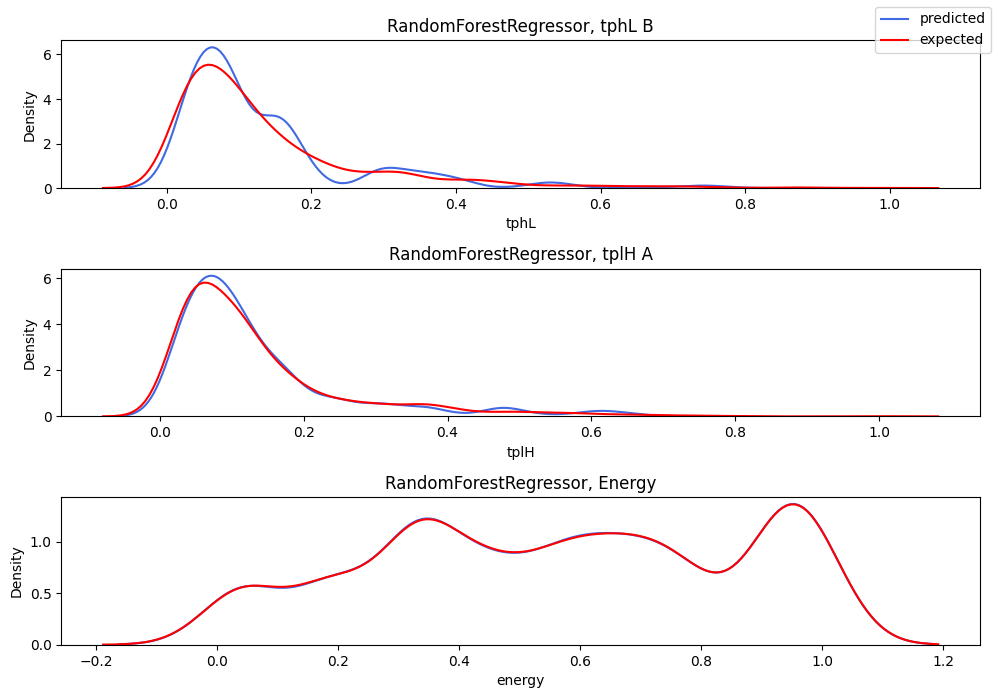

In [60]:
clfs = [RandomForestRegressor(random_state = seed)]
fig, ax = plt.subplots(3,1, figsize = (10,7))

logging.info("==== results_cv ====")

#modelos para TPHL
print('label: TPHL')
logging.info('label: TPHL')
for idx,clf in enumerate(clfs):
    i = idx
    clf.set_params(n_estimators = 100,
                   max_depth = 4)
    clf = clf.fit(X_train, y_train.tphL)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tphL, ypred)
    r2 = r2_score(y_val.tphL, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[0],color = 'royalblue')
    sns.kdeplot(data=y_val.tphL, label = 'true', ax = ax[0], color = 'red')
    ax[0].set_title(f'{clf.__class__.__name__}, tphL B')

#modelos para TPLH
print('label: TPLH')
logging.info('label: TPLH')
for idx,clf in enumerate(clfs):
    i = idx
    clf.set_params(n_estimators = 100,
                   max_depth = 5)
    clf = clf.fit(X_train, y_train.tplH)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tplH, ypred)
    r2 = r2_score(y_val.tplH, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[1],color = 'royalblue')
    sns.kdeplot(data=y_val.tplH, label = 'true', ax = ax[1], color = 'red')
    ax[1].set_title(f'{clf.__class__.__name__}, tplH A')

#modelos para IINT
print('label: IINT')
logging.info('label: IINT')
for idx,clf in enumerate(clfs):
    i = idx
    clf.set_params(n_estimators = 50,
                   max_depth = 4)
    clf = clf.fit(X_train, y_train.energy)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.energy, ypred)
    r2 = r2_score(y_val.energy, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2} (max_depth = 4)')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[2],color = 'royalblue')
    sns.kdeplot(data=y_val.energy, label = 'true', ax = ax[2], color = 'red')
    ax[2].set_title(f'{clf.__class__.__name__}, Energy')

plt.tight_layout()
fig.legend(labels=["predicted", "expected"])
plt.savefig(results_dir + 'RF_all_best_hyperparams_nand.pdf')
plt.show()

In [61]:
print(f"tphl = {sqrt(0.0017787240182748534)}, tplh = {sqrt(0.0010517339666670997)}, energy = {sqrt(5.512323146026393e-05)}")

tphl = 0.04217492167479216, tplh = 0.03243044814163227, energy = 0.007424502101842516


label: IINT
clf: RandomForestRegressor, mse: 3.770493527967202e-05, r2: 0.9995712826261735


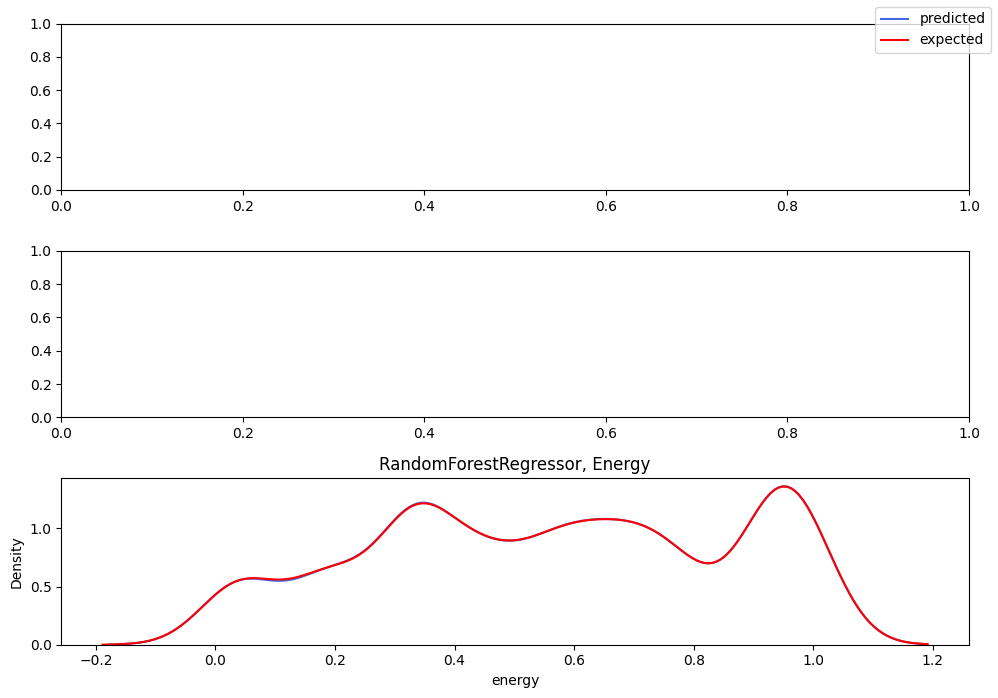

In [62]:
clfs = [RandomForestRegressor(random_state = seed)]
fig, ax = plt.subplots(3,1, figsize = (10,7))

logging.info("==== results_test_set ====")

#modelos para IINT
print('label: IINT')
logging.info('label: IINT')
for idx,clf in enumerate(clfs):
    i = idx
    clf.set_params(n_estimators = 50,
                   max_depth = 10)
    clf = clf.fit(X_train, y_train.energy)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.energy, ypred)
    r2 = r2_score(y_val.energy, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2} (max_depth = 4)')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[2],color = 'royalblue')
    sns.kdeplot(data=y_val.energy, label = 'true', ax = ax[2], color = 'red')
    ax[2].set_title(f'{clf.__class__.__name__}, Energy')

plt.tight_layout()
fig.legend(labels=["predicted", "expected"])
plt.savefig(results_dir + 'RF_all_best_hyperparams_nand.pdf')
plt.show()

clf: RandomForestRegressor, mse: 5.512323146026393e-05, r2: 0.9993732309350702


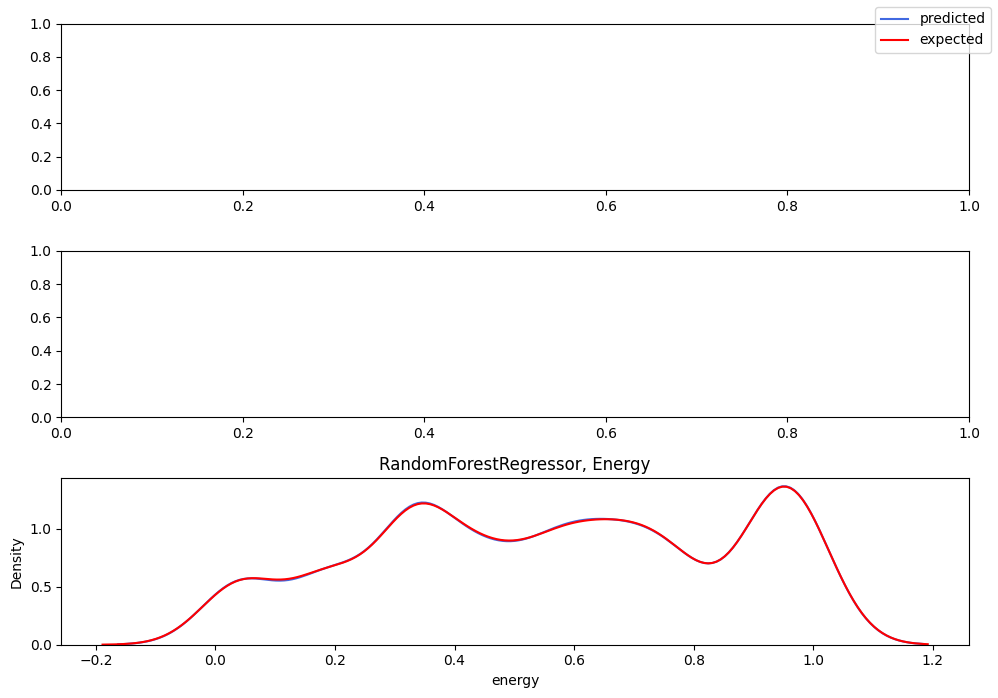

In [63]:
clfs = [RandomForestRegressor(random_state = seed)]
fig, ax = plt.subplots(3,1, figsize = (10,7))

clf.set_params(n_estimators = 50,
                   max_depth = 4)
clf = clf.fit(X_train, y_train.energy)
ypred = clf.predict(X_val)
mse = mean_squared_error(y_val.energy, ypred)
r2 = r2_score(y_val.energy, ypred)

sns.kdeplot(data=ypred, label = 'predicted', ax = ax[2],color = 'royalblue')
sns.kdeplot(data=y_val.energy, label = 'true', ax = ax[2], color = 'red')
ax[2].set_title(f'{clf.__class__.__name__}, Energy')
print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
plt.tight_layout()
fig.legend(labels=["predicted", "expected"])
plt.savefig(results_dir + 'RF_all_best_hyperparams_nand.pdf')
plt.show()



In [64]:
pd.Series(ypred).unique()

array([0.69986444, 0.33467379, 0.44481872, 0.18943058, 0.77251853,
       0.99036098, 0.91211338, 0.33079732, 0.77185992, 0.77257578,
       0.33423969, 0.55348747, 0.95408425, 0.77251303, 0.04339081,
       0.55354341, 0.33589546, 0.99059713, 0.7733359 , 0.91703308,
       0.33391919, 0.91193102, 0.62828831, 0.9180709 , 0.55369854,
       0.33939351, 0.91684072, 0.91794352, 0.03892054, 0.77191717,
       0.62818329, 0.77288992, 0.91180364, 0.62741774, 0.62502458,
       0.55340096, 0.55386417, 0.91787854, 0.77197713, 0.55316671,
       0.77327865, 0.04311194, 0.62765955, 0.77339585, 0.9108932 ,
       0.77295267, 0.77263574, 0.62512961, 0.77179447, 0.55377766,
       0.0383712 , 0.03088584, 0.03814269, 0.91775116, 0.04323316,
       0.91107556, 0.62466305, 0.03716486, 0.77245307, 0.62535137,
       0.33435329, 0.04130098, 0.33557496, 0.91198601, 0.77327314,
       0.77321319, 0.55362754, 0.04021099, 0.33907301, 0.77262397,
       0.33982761, 0.77185442, 0.77301263, 0.91173866, 0.33632

In [65]:
pd.DataFrame(ypred).to_csv("./predito")
pd.DataFrame(y_val.energy).to_csv("./esperado")

label: IINT
clf: RandomForestRegressor, mse: 0.006788214148118765, r2: 0.9241368243124053


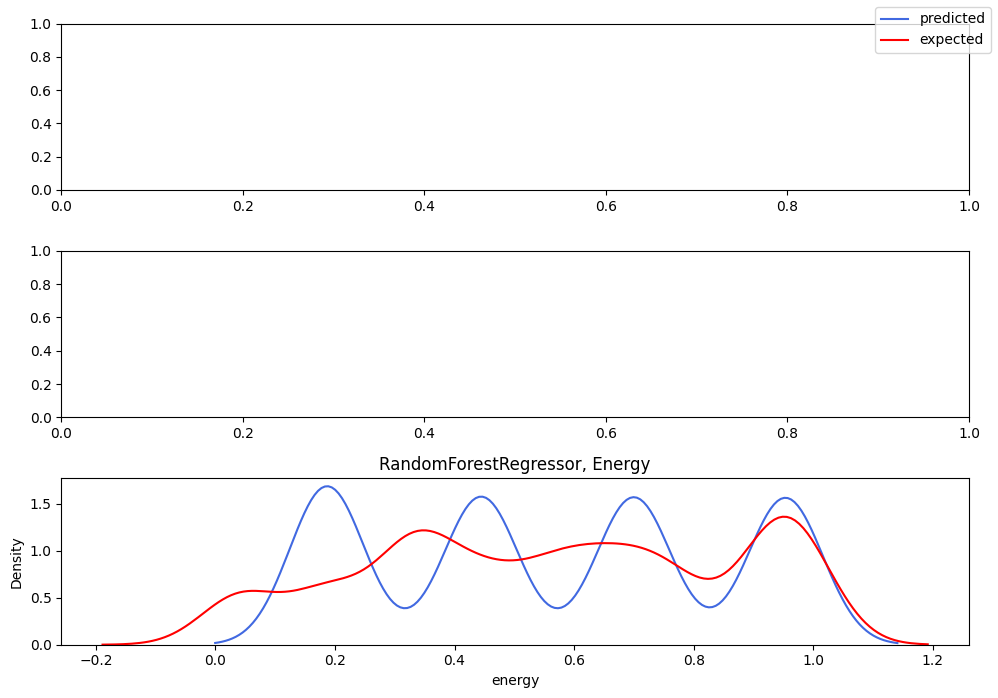

In [66]:
fig, ax = plt.subplots(3,1, figsize = (10,7))

clf.set_params(n_estimators = 50,
                   max_depth = 2)
clf = clf.fit(Xtr_sc, ytr.energy)
ypred = clf.predict(Xte_sc)
mse = mean_squared_error(yte.energy, ypred)
r2 = r2_score(yte.energy, ypred)
print('label: IINT')
print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
sns.kdeplot(data=ypred, label = 'predicted', ax = ax[2],color = 'royalblue')
sns.kdeplot(data=y_val.energy, label = 'true', ax = ax[2], color = 'red')
ax[2].set_title(f'{clf.__class__.__name__}, Energy')

plt.tight_layout()
fig.legend(labels=["predicted", "expected"])
plt.savefig(results_dir + 'RF_all_best_hyperparams_nand.pdf')
plt.show()

### SVR RBF

label: TPHL
clf: SVR, mse: 0.002359701592081698, r2: 0.8701151246534969
label: TPLH
clf: SVR, mse: 0.0030155081060025696, r2: 0.8106761143873934
label: IINT
clf: SVR, mse: 0.0021983950637110474, r2: 0.9750035333211241


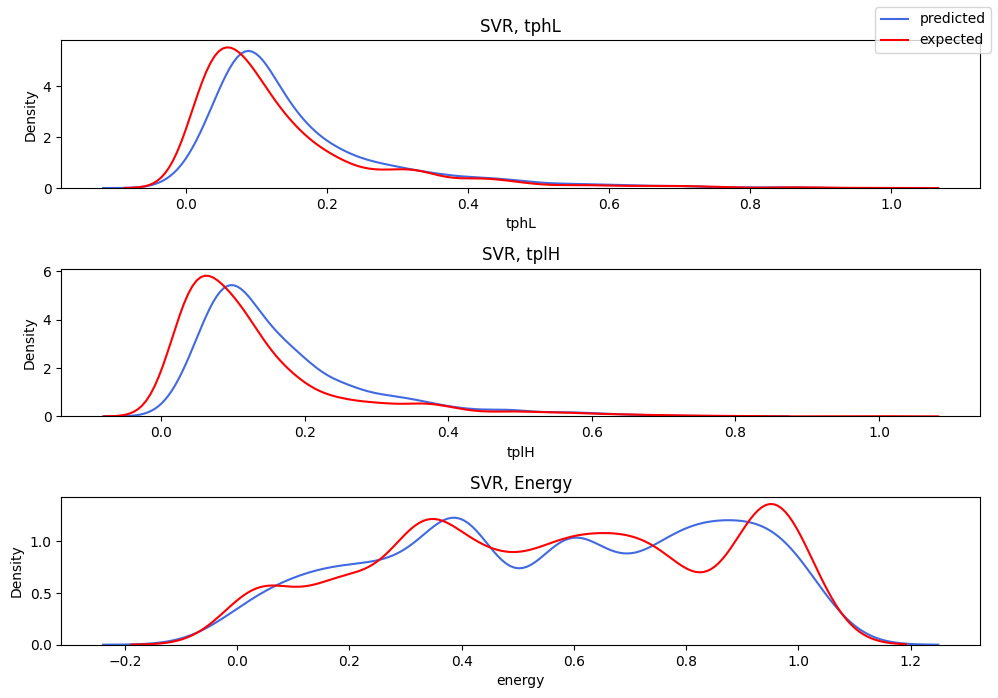

In [67]:
clfs = [SVR(kernel='rbf')]
fig, ax = plt.subplots(3,1, figsize = (10,7))

logging.info("==== results_cv ====")

#modelos para TPHL
print('label: TPHL')
logging.info('label: TPHL')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.tphL)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tphL, ypred)
    r2 = r2_score(y_val.tphL, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[0],color = 'royalblue')
    sns.kdeplot(data=y_val.tphL, label = 'true', ax = ax[0], color = 'red')
    ax[0].set_title(f'{clf.__class__.__name__}, tphL')

#modelos para TPLH
print('label: TPLH')
logging.info('label: TPLH')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.tplH)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tplH, ypred)
    r2 = r2_score(y_val.tplH, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[1],color = 'royalblue')
    sns.kdeplot(data=y_val.tplH, label = 'true', ax = ax[1], color = 'red')
    ax[1].set_title(f'{clf.__class__.__name__}, tplH')

#modelos para IINT
print('label: IINT')
logging.info('label: IINT')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.energy)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.energy, ypred)
    r2 = r2_score(y_val.energy, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2} (max_depth = 4)')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[2],color = 'royalblue')
    sns.kdeplot(data=y_val.energy, label = 'true', ax = ax[2], color = 'red')
    ax[2].set_title(f'{clf.__class__.__name__}, Energy')

plt.tight_layout()
fig.legend(labels=["predicted", "expected"])
plt.savefig(results_dir + 'RF_all_best_hyperparams_nand.pdf')
plt.show()

In [68]:
print(f"tphl = {sqrt(0.002359701592081698)}, tplh = {sqrt(0.0030155081060025696)}, energy = {sqrt(0.0021983950637110474)}")

tphl = 0.04857675979397656, tplh = 0.0549136422576628, energy = 0.04688704579850438


# Neural Networks

In [69]:
import tensorflow as tf

ModuleNotFoundError: No module named 'tensorflow'

## Neural Net #0 (Try hard mode)

In [ ]:
ann = tf.keras.models.Sequential()

In [ ]:
#Hidden Layer 1
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
#Hidden Layer 2
ann.add(tf.keras.layers.Dense(units=9, activation='relu'))
#Hidden Layer 3
ann.add(tf.keras.layers.Dense(units=12, activation='relu'))
#Output Layer
ann.add(tf.keras.layers.Dense(units=1))

In [ ]:
ann.compile(optimizer='adam', loss='mean_squared_error')

###**TPHL**

In [ ]:
ann.fit(X_train,y_train.tphl, batch_size=40, epochs=50)

Epoch 1/50
5777/5777 [==============================] - 7s 1ms/step - loss: 0.0054
Epoch 2/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.3023e-04
Epoch 3/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.3005e-04
Epoch 4/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.0970e-04
Epoch 5/50
5777/5777 [==============================] - 7s 1ms/step - loss: 9.3712e-05
Epoch 6/50
5777/5777 [==============================] - 7s 1ms/step - loss: 8.6630e-05
Epoch 7/50
5777/5777 [==============================] - 7s 1ms/step - loss: 8.4781e-05
Epoch 8/50
5777/5777 [==============================] - 7s 1ms/step - loss: 8.2229e-05
Epoch 9/50
5777/5777 [==============================] - 7s 1ms/step - loss: 8.0173e-05
Epoch 10/50
5777/5777 [==============================] - 7s 1ms/step - loss: 7.6979e-05
Epoch 11/50
5777/5777 [==============================] - 7s 1ms/step - loss: 7.4878e-05
Epoch 12/50
5777/5777 [======================

In [ ]:
ypred = ann.predict(X_val)
mse = mean_squared_error(y_val.tphl, ypred)
print(f'clf: ANN, mse: {mse}')

clf: ANN, mse: 5.659724973517145e-05


Text(0.5, 1.0, 'ANN, TPHL')

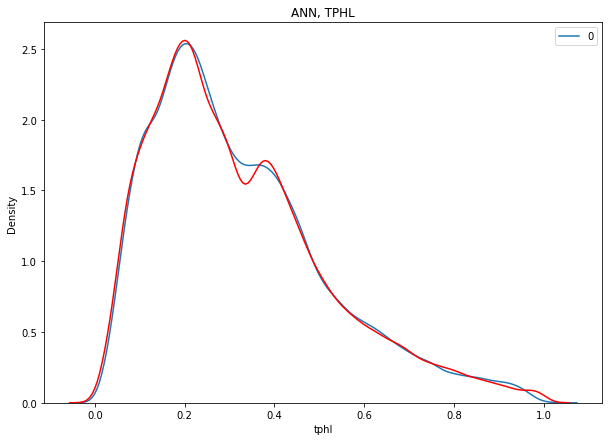

In [ ]:
fig_tphl, ax = plt.subplots(1,1, figsize = (10,7))
sns.kdeplot(data=ypred, label = 'predicted', ax = ax,color = 'royalblue')
sns.kdeplot(data=y_val.tphl, label = 'true', ax = ax, color = 'red')
ax.set_title('ANN, TPHL')

###**TPLH**

In [ ]:
ann.fit(X_train,y_train.tplh, batch_size=40, epochs=50)

Epoch 1/50
5777/5777 [==============================] - 7s 1ms/step - loss: 5.3271e-04
Epoch 2/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.6928e-04
Epoch 3/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.5479e-04
Epoch 4/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.4872e-04
Epoch 5/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.4467e-04
Epoch 6/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.4033e-04
Epoch 7/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.3642e-04
Epoch 8/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.3444e-04
Epoch 9/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.3278e-04
Epoch 10/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.3065e-04
Epoch 11/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.3020e-04
Epoch 12/50
5777/5777 [==================

In [ ]:
ypred = ann.predict(X_val)
mse = mean_squared_error(y_val.tplh, ypred)
print(f'clf: ANN, mse: {mse}')

clf: ANN, mse: 0.00010841889629696702


Text(0.5, 1.0, 'ANN, TPLH')

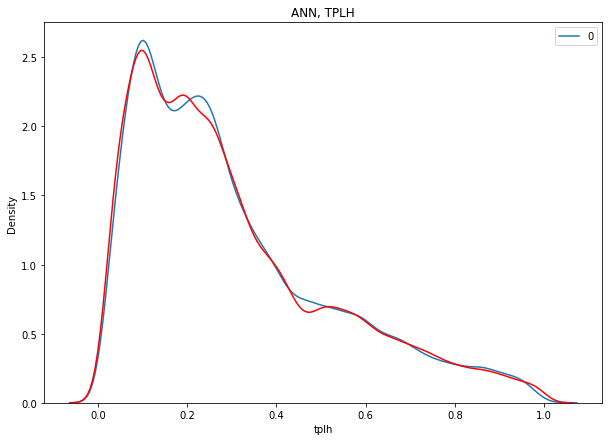

In [ ]:
fig_tplh, ax = plt.subplots(1,1, figsize = (10,7))
sns.kdeplot(data=ypred, label = 'predicted', ax = ax,color = 'royalblue')
sns.kdeplot(data=y_val.tplh, label = 'true', ax = ax, color = 'red')
ax.set_title('ANN, TPLH')

###**IINT**

In [ ]:
ann.fit(X_train,y_train.iint, batch_size=40, epochs=50)

Epoch 1/50
5777/5777 [==============================] - 7s 1ms/step - loss: 0.0015
Epoch 2/50
5777/5777 [==============================] - 7s 1ms/step - loss: 3.2178e-04
Epoch 3/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.9526e-04
Epoch 4/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.8470e-04
Epoch 5/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.7587e-04
Epoch 6/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.7122e-04
Epoch 7/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.6758e-04
Epoch 8/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.6661e-04
Epoch 9/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.6319e-04
Epoch 10/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.5917e-04
Epoch 11/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.4992e-04
Epoch 12/50
5777/5777 [======================

In [ ]:
ypred = ann.predict(X_val)
mse = mean_squared_error(y_val.iint, ypred)
print(f'clf: ANN, mse: {mse}')

clf: ANN, mse: 0.00016256548097748116


Text(0.5, 1.0, 'ANN, IINT')

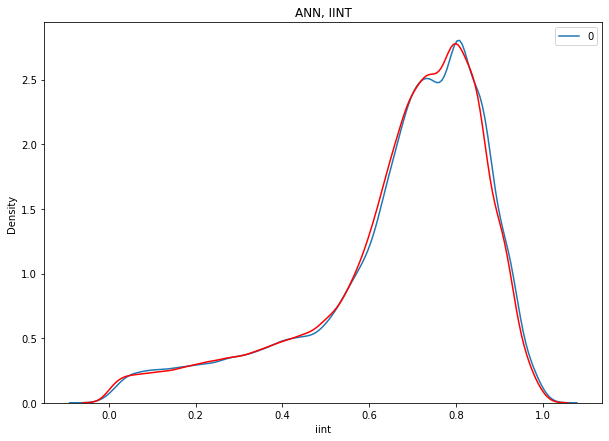

In [ ]:
fig_iint, ax = plt.subplots(1,1, figsize = (10,7))
sns.kdeplot(data=ypred, label = 'predicted', ax = ax,color = 'royalblue')
sns.kdeplot(data=y_val.iint, label = 'true', ax = ax, color = 'red')
ax.set_title('ANN, IINT')

## Neural Net #1 (Multilayer Perceptron Sklearn)

In [ ]:
from sklearn.neural_network import MLPRegressor

In [ ]:
# criando o objeto do modelo com MLPRegressor
neural_network_model = MLPRegressor(activation='tanh', 
                                    solver = 'lbfgs',
                                    hidden_layer_sizes=(100, ),
                                    early_stopping = True, )

###TPHL

In [ ]:
# treinando o modelo com os dados de treino
neural_network_model.fit(X_train, y_train.tphl)

# prever com o modelo nos dados de validacao
y_pred = neural_network_model.predict(X_val)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
mse = mean_squared_error(y_val.tphl, y_pred)
print(f'clf: MLP, mse: {mse}')

clf: MLP, mse: 0.0012760736147303222


Text(0.5, 1.0, 'MLP, TPHL')

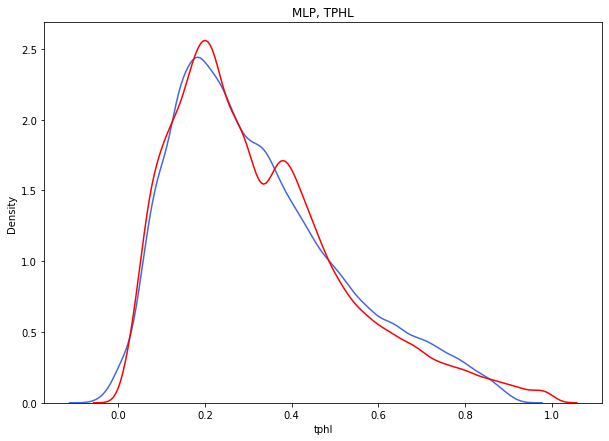

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (10,7))
sns.kdeplot(data=y_pred, label = 'predicted', ax = ax,color = 'royalblue')
sns.kdeplot(data=y_val.tphl, label = 'true', ax = ax, color = 'red')
ax.set_title('MLP, TPHL')

Score on training set: 0.967
Score on validation set: 0.967
Mean squared error (MSE): 0.0012760736147303222


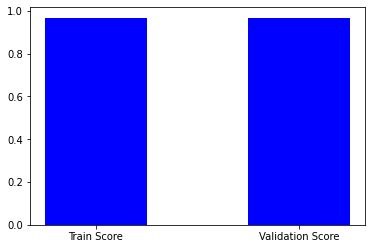

In [ ]:
print("Score on training set: {:.3f}".format(neural_network_model.score(X_train, y_train.tphl)))
print("Score on validation set: {:.3f}".format(neural_network_model.score(X_val, y_val.tphl)))
y = [neural_network_model.score(X_train, y_train.tphl), 
     neural_network_model.score(X_val, y_val.tphl)]
x = ["Train Score", "Validation Score"]
width = 1/2
plt.bar(x, y, width, color="blue") 
#print("Explained variance score: {}".format(explained_variance_score(y_val.tphl, y_pred)))
#print("Mean absolute error (MAE): {}".format(mean_absolute_error(y_val.tphl, y_pred)))
print("Mean squared error (MSE): {}".format(mean_squared_error(y_val.tphl, y_pred)))
#print("R² Score: {:.3f}".format(r2_score(y_val.tphl, y_pred)))

###TPLH

In [ ]:
# treinando o modelo com os dados de treino
neural_network_model.fit(X_train, y_train.tplh)

# prever com o modelo nos dados de validacao
y_pred = neural_network_model.predict(X_val)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
mse = mean_squared_error(y_val.tplh, y_pred)
print(f'clf: MLP, mse: {mse}')

clf: MLP, mse: 0.0003523014496010987


Text(0.5, 1.0, 'MLP, TPLH')

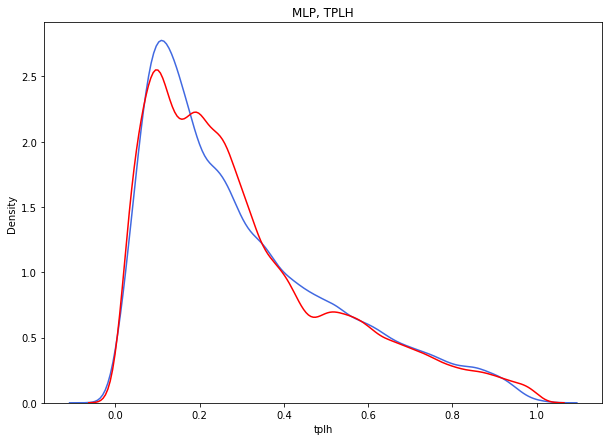

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (10,7))
sns.kdeplot(data=y_pred, label = 'predicted', ax = ax,color = 'royalblue')
sns.kdeplot(data=y_val.tplh, label = 'true', ax = ax, color = 'red')
ax.set_title('MLP, TPLH')

Score on training set: 0.993
Score on validation set: 0.993
Mean squared error (MSE): 0.0003523014496010987


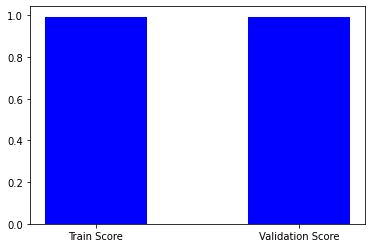

In [ ]:
print("Score on training set: {:.3f}".format(neural_network_model.score(X_train, y_train.tplh)))
print("Score on validation set: {:.3f}".format(neural_network_model.score(X_val, y_val.tplh)))
y = [neural_network_model.score(X_train, y_train.tplh), 
     neural_network_model.score(X_val, y_val.tplh)]
x = ["Train Score", "Validation Score"]
width = 1/2
plt.bar(x, y, width, color="blue") 
#print("Explained variance score: {}".format(explained_variance_score(y_val.tphl, y_pred)))
#print("Mean absolute error (MAE): {}".format(mean_absolute_error(y_val.tphl, y_pred)))
print("Mean squared error (MSE): {}".format(mean_squared_error(y_val.tplh, y_pred)))
#print("R² Score: {:.3f}".format(r2_score(y_val.tphl, y_pred)))

###IINT

In [ ]:
# treinando o modelo com os dados de treino
neural_network_model.fit(X_train, y_train.iint)

# prever com o modelo nos dados de validacao
y_pred = neural_network_model.predict(X_val)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
mse = mean_squared_error(y_val.iint, y_pred)
print(f'clf: MLP, mse: {mse}')

clf: MLP, mse: 0.0005599333245738104


Text(0.5, 1.0, 'MLP, IINT')

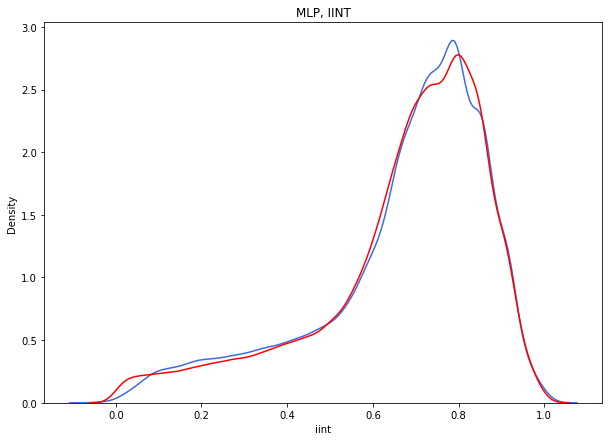

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (10,7))
sns.kdeplot(data=y_pred, label = 'predicted', ax = ax,color = 'royalblue')
sns.kdeplot(data=y_val.iint, label = 'true', ax = ax, color = 'red')
ax.set_title('MLP, IINT')

Score on training set: 0.987
Score on validation set: 0.987
Mean squared error (MSE): 0.0005599333245738104


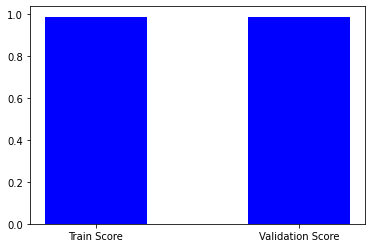

In [ ]:
print("Score on training set: {:.3f}".format(neural_network_model.score(X_train, y_train.iint)))
print("Score on validation set: {:.3f}".format(neural_network_model.score(X_val, y_val.iint)))
y = [neural_network_model.score(X_train, y_train.iint), 
     neural_network_model.score(X_val, y_val.iint)]
x = ["Train Score", "Validation Score"]
width = 1/2
plt.bar(x, y, width, color="blue") 
#print("Explained variance score: {}".format(explained_variance_score(y_val.tphl, y_pred)))
#print("Mean absolute error (MAE): {}".format(mean_absolute_error(y_val.tphl, y_pred)))
print("Mean squared error (MSE): {}".format(mean_squared_error(y_val.iint, y_pred)))
#print("R² Score: {:.3f}".format(r2_score(y_val.tphl, y_pred)))

# Old Models



## Neural Net #0 (Try hard mode)

In [ ]:
import tensorflow as tf

In [ ]:
ann = tf.keras.models.Sequential()

Vou fazer apenas um output inicialmente (tphl, coluna 0) para ver como performa, abaixo é o código para a arquitetura e compilação com backpropagation. Vou fazer sem padronizar os dados de treinamento inicialmente

In [ ]:
#Hidden Layer 1
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
#Hidden Layer 2
ann.add(tf.keras.layers.Dense(units=9, activation='relu'))
#Hidden Layer 3
ann.add(tf.keras.layers.Dense(units=12, activation='relu'))
#Output Layer
ann.add(tf.keras.layers.Dense(units=1))

In [ ]:
ann.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
validation_tphl = y_val.tphl
train_tphl = y_train.tphl
test_tphl = yte

Bruh, o loss diminuiu bastante e até convergiu no epoch 6, mas as predições estão constantes... wtf? Tentarei normalizar, vamos ver se altera algo, se não é mexer na arquitetura pq o modelo não está aprendendo. Aparentemente o sem alterar os dados convergiu no 30 epoch tmb. Scheisse. A normalização ainda converge, porém os resultados constantes são mais próximos da escala esperada. Vou trabalhar com ela e ver se altero a arquitetura e outros parãmetros como o batch size. O batch size e as units não me parecem trazer alterações relevantes. Vou adicionar mais Layers na esperança de a ann aprender algo a mais, minha última alternativa é alterar a composição do dataset. O aumento para 4 layers com 12 units piorou os resultados

In [ ]:
ann.fit(X_train,train_tphl, batch_size=40, epochs=50)

In [ ]:
y_pred_nn0 = ann.predict(X_val)
#np.set_printoptions(precision=2)
print(np.concatenate((y_pred_nn0.reshape(len(y_pred_nn0),1), a.reshape(len(a),1)), axis=1))

## Neural Net #1 (Multilayer Perceptron Sklearn)

In [ ]:
from sklearn.neural_network import MLPRegressor

In [ ]:
"""from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_val_scaled = sc.transform(X_val)"""

In [ ]:
# criando o objeto do modelo com MLPRegressor
neural_network_model = MLPRegressor(activation='tanh', 
                                    solver = 'lbfgs',
                                    hidden_layer_sizes=(100),
                                    early_stopping = True)

# treinando o modelo com os dados de treino
neural_network_model.fit(X_train_norm, train_tphl)

# prever com o modelo nos dados de validacao
y_pred = neural_network_model.predict(X_val_norm)

In [ ]:
print(np.concatenate((y_pred.reshape(len(y_pred),1), validation_tphl.reshape(len(validation_tphl),1)), axis=1))

[[-1.35e-04  9.68e-12]
 [ 1.02e-04  1.35e-11]
 [-5.48e-03  7.57e-12]
 ...
 [-1.57e-04  8.69e-12]
 [-1.75e-04  1.37e-11]
 [-1.91e-04  5.91e-12]]


Score on training set: -598198417686226560.000
Score on validation set: -601938109190083200.000
Explained variance score: -6.019363056862876e+17
Mean absolute error (MAE): 0.002912541559344496
Mean squared error (MSE): 1.3897360339482752e-05
R² Score: -601938109190083200.000


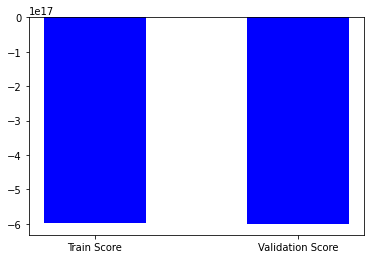

In [ ]:
print("Score on training set: {:.3f}".format(neural_network_model.score(X_train_norm, train_tphl)))
print("Score on validation set: {:.3f}".format(neural_network_model.score(X_val_norm, validation_tphl)))
y = [neural_network_model.score(X_train_norm, train_tphl), 
     neural_network_model.score(X_val_norm, validation_tphl)]
x = ["Train Score", "Validation Score"]
width = 1/2
plt.bar(x, y, width, color="blue") 
print("Explained variance score: {}".format(explained_variance_score(validation_tphl, y_pred)))
print("Mean absolute error (MAE): {}".format(mean_absolute_error(validation_tphl, y_pred)))
print("Mean squared error (MSE): {}".format(mean_squared_error(validation_tphl, y_pred)))
print("R² Score: {:.3f}".format(r2_score(validation_tphl, y_pred)))

##Neural Net #2 (Keras with multioutput)

In [ ]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
# get the model
def get_model(n_inputs, n_outputs):
	model = Sequential()
	model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mae', optimizer='adam')
	return model
  
# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
	results = list()
	n_inputs, n_outputs = 7, 3
	# define evaluation procedure
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	# enumerate folds
	for train_ix, test_ix in cv.split(X):
		# prepare data
		X_train, X_test = X[train_ix], X[test_ix]
		y_train, y_test = y[train_ix], y[test_ix]
		# define model
		model = get_model(n_inputs, n_outputs)
		# fit model
		model.fit(X_train, y_train, verbose=0, epochs=100)
		# evaluate model on test set
		mae = model.evaluate(X_test, y_test, verbose=0)
		# store result
		print('>%.3f' % mae)
		results.append(mae)
	return results

# evaluate model
results = evaluate_model(X, y)
# summarize performance
print('MAE: %.3f (%.3f)' % (mean(results), std(results)))

TypeError: ignored

In [ ]:
def get_model(n_inputs, n_outputs):
	model = Sequential()
	model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
	model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
	model.compile(loss='mae', optimizer='adam')
	return model
 
# load dataset
n_inputs, n_outputs = X.shape[1], y.shape[1]
# get model
model = get_model(n_inputs, n_outputs)
# fit the model on all data
model.fit(X_train, y_train, verbose=0, epochs=100)
# make a prediction for new data
yhat = model.predict(X_val)
print('Predicted: %s' % yhat[0])

## Random Forest MultiOutput

In [ ]:
##### RandomForest tphl
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

rf_model =  MultiOutputRegressor(RandomForestRegressor(random_state=seed)).fit(X_train, y_train)

y_pred_1 = rf_model.predict(X_val)

In [ ]:
print(np.concatenate((y_pred_1.reshape(len(y_pred_1),3), y_val.reshape(len(y_val),3)), axis=1))

[[ 1.25e-11  2.34e-11 -1.46e-15  9.68e-12  1.84e-11 -1.20e-15]
 [ 1.25e-11  2.34e-11 -1.46e-15  1.35e-11  1.43e-11 -9.02e-16]
 [ 1.25e-11  2.34e-11 -1.46e-15  7.57e-12  8.73e-12 -1.49e-15]
 ...
 [ 1.25e-11  2.34e-11 -1.46e-15  8.69e-12  1.75e-11 -1.64e-15]
 [ 1.25e-11  2.34e-11 -1.46e-15  1.37e-11  2.35e-11 -1.36e-15]
 [ 1.25e-11  2.34e-11 -1.46e-15  5.91e-12  3.01e-11 -2.11e-15]]


In [ ]:
print("Score on training set: {}".format(rf_model_1.score(X_train, y_train)))
print("Score on validation set: {}".format(rf_model_1.score(X_val, y_val)))

print("Explained variance score: {}".format(explained_variance_score(y_val, y_pred_1, multioutput='raw_values')))
print("Mean absolute error (MAE): {}".format(mean_absolute_error(y_val, y_pred_1, multioutput='raw_values')))
print("Mean squared error (MSE): {}".format(mean_squared_error(y_val, y_pred_1, multioutput='raw_values')))

Score on training set: -2.6624674613155246e-08
Score on validation set: -7.082762035685401e-06
Explained variance score: [5.33e-15 1.89e-15 2.00e-15]
Mean absolute error (MAE): [3.85e-12 1.14e-11 3.63e-16]
Mean squared error (MSE): [2.31e-23 2.03e-22 2.25e-31]


In [ ]:
from sklearn.model_selection import GridSearchCV
"""
params = {'n_estimators': [5, 50, 100, 500],
          'max_features': [2, 5, 7],
          'max_depth': [2, 5, 10, 50],
          'min_samples_split': [2, 8, 15, 30],}

# criando o objeto do modelo com RandomForestRegressor
rf_model_cv_gs = RandomForestRegressor(random_state = seed)

# criando o objeto do grid search com GridSearchCV
grid_search = GridSearchCV(rf_model_cv_gs, param_grid=params, return_train_score=True) # valor padrão para quebras é 3

# treinando o modelo com o grid search
grid_search.fit(X_training, y_training)

# imprimindo a melhor combinação de hiperparâmetros
print('\n Best hyperparameters:')
print(grid_search.best_params_)

# pegando os resultados da validação cruzada (cv_results)
cv_results = pd.DataFrame(grid_search.cv_results_)

# imprimindo o score médio nas bases de treino
print("Average Score on train set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_train_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_train_score.values[0]))
# imprimindo o score médio nas bases de validação
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_test_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_test_score.values[0])) """

'\nparams = {\'n_estimators\': [5, 50, 100, 500],\n          \'max_features\': [2, 5, 7],\n          \'max_depth\': [2, 5, 10, 50],\n          \'min_samples_split\': [2, 8, 15, 30],}\n\n# criando o objeto do modelo com RandomForestRegressor\nrf_model_cv_gs = RandomForestRegressor(random_state = seed)\n\n# criando o objeto do grid search com GridSearchCV\ngrid_search = GridSearchCV(rf_model_cv_gs, param_grid=params, return_train_score=True) # valor padrão para quebras é 3\n\n# treinando o modelo com o grid search\ngrid_search.fit(X_training, y_training)\n\n# imprimindo a melhor combinação de hiperparâmetros\nprint(\'\n Best hyperparameters:\')\nprint(grid_search.best_params_)\n\n# pegando os resultados da validação cruzada (cv_results)\ncv_results = pd.DataFrame(grid_search.cv_results_)\n\n# imprimindo o score médio nas bases de treino\nprint("Average Score on train set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_train_score.values[0],\n                  

In [ ]:
"""Best hyperparameters:
{'max_depth': 2, 'max_features': 2, 'min_samples_split': 2, 'n_estimators': 100}
Average Score on train set: -0.000 +/- 0.000
Average Score on validation set: -0.000 +/- 0.000"""

# configurando o modelo com a melhor combinação de hiperparâmetros
"""rf_model_cv_gs.set_params(n_estimators = grid_search.best_params_['n_estimators'],
                           max_features = grid_search.best_params_['max_features'],
                           max_depth = grid_search.best_params_['max_depth'],
                           min_samples_split = grid_search.best_params_['min_samples_split'])"""

rf_model_cv_gs = RandomForestRegressor(random_state = seed)

rf_model_cv_gs.set_params(n_estimators = 100,
                           max_features = 2,
                           max_depth = 2,
                           min_samples_split = 2)
# treinando um modelo com a melhor combinação de hiperparâmetros
rf_model_cv_gs.fit(normalize(X_training), y_training)

"""features = X_train.columns
importances = rf_model_cv_gs.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()"""

"features = X_train.columns\nimportances = rf_model_cv_gs.feature_importances_\nindices = np.argsort(importances)\n\nplt.title('Feature Importances')\nplt.barh(range(len(indices)), importances[indices], color='b', align='center')\nplt.yticks(range(len(indices)), [features[i] for i in indices])\nplt.xlabel('Relative Importance')\nplt.show()"

In [ ]:
pred = rf_model_cv_gs.predict(normalize(X_test))
print(np.concatenate((pred.reshape(len(pred),3), y_test.reshape(len(y_test),3)), axis=1))

[[ 1.25e-11  2.34e-11 -1.46e-15  6.59e-12  7.30e-12 -2.95e-15]
 [ 1.25e-11  2.34e-11 -1.46e-15  6.78e-12  5.21e-12 -1.90e-15]
 [ 1.25e-11  2.34e-11 -1.46e-15  9.29e-12  1.76e-11 -1.44e-15]
 ...
 [ 1.25e-11  2.34e-11 -1.46e-15  8.86e-12  1.34e-11 -1.41e-15]
 [ 1.25e-11  2.34e-11 -1.46e-15  1.53e-11  2.20e-11 -1.52e-15]
 [ 1.25e-11  2.34e-11 -1.46e-15  6.49e-12  5.95e-12 -1.60e-15]]


##SVR Polynomial MultiOutput


In [ ]:
from sklearn.svm import SVR
SVR = MultiOutputRegressor(SVR(kernel = 'linear')).fit(normalize(X_train), y_train) # kernel='rbf', C, gamma
svr_pred = SVR.predict(normalize(X_val))

In [ ]:
print(np.concatenate((svr_pred.reshape(len(svr_pred),3), y_val.reshape(len(y_val),3)), axis=1))

[[ 1.68e-11  3.61e-11 -1.85e-15  9.68e-12  1.84e-11 -1.20e-15]
 [ 1.68e-11  3.61e-11 -1.85e-15  1.35e-11  1.43e-11 -9.02e-16]
 [ 1.68e-11  3.61e-11 -1.85e-15  7.57e-12  8.73e-12 -1.49e-15]
 ...
 [ 1.68e-11  3.61e-11 -1.85e-15  8.69e-12  1.75e-11 -1.64e-15]
 [ 1.68e-11  3.61e-11 -1.85e-15  1.37e-11  2.35e-11 -1.36e-15]
 [ 1.68e-11  3.61e-11 -1.85e-15  5.91e-12  3.01e-11 -2.11e-15]]


In [ ]:
print("Score on training set: {}".format(rf_model_1.score(X_train, y_train)))
print("Score on validation set: {}".format(rf_model_1.score(X_val, y_val)))

print("Explained variance score: {}".format(explained_variance_score(y_val, svr_pred, multioutput='raw_values')))
print("Mean absolute error (MAE): {}".format(mean_absolute_error(y_val, svr_pred, multioutput='raw_values')))
print("Mean squared error (MSE): {}".format(mean_squared_error(y_val, svr_pred, multioutput='raw_values')))

Score on training set: -2.6624674613155246e-08
Score on validation set: -7.082762035685401e-06
Explained variance score: [ 5.44e-15  1.89e-15 -6.66e-16]
Mean absolute error (MAE): [5.68e-12 1.71e-11 5.51e-16]
Mean squared error (MSE): [4.19e-23 3.64e-22 3.75e-31]


# Results

In [ ]:
from sklearn.metrics import (explained_variance_score, 
                             mean_absolute_error, 
                             mean_squared_error, 
                             mean_squared_log_error,
                             r2_score)

In [ ]:
def generate_model_scores_df(score,y_pred,model_name,new_df=True,df=None):
  if new_df:
    result = pd.DataFrame(columns=['TPHL', 'TPLH', 'IINT'], index=[model_name])
  else:
    result = df
  result.loc[model_name] = score(y_val, y_pred, multioutput='raw_values')
  return result

In [ ]:
sim_0 = pd.read_csv('/content/drive/MyDrive/UFSC (12019-12023)/PIC/Cmos Data/results_sim0.csv')

In [ ]:
#regre = mean_absolute_error(y_val, y_p, multioutput='raw_values')
randf1 = mean_absolute_error(y_val, y_pred_1, multioutput='raw_values')
#randf2 = mean_absolute_error(y_val, y_pred_2, multioutput='raw_values')
NN = mean_absolute_error(y_val,y_pred, multioutput='raw_values')
#NN2 = mean_absolute_error(y_val,yhat, multioutput='raw_values')

In [ ]:
metricas = pd.DataFrame([randf1,NN],index=['Floresta','MLP'],columns=['tphl','tplh','iint'])

In [ ]:
metricas

tphl          tplh          iint
Floresta  3.846058e-12  1.137435e-11  3.628414e-16
MLP       3.030069e-04  8.922528e-05  9.800367e-05